<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/Again_Training_Exp05_Just_20Epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
* Try Again, Fin...Fin...Fin...!!
* back to Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum
* Add 
    * plot train, test loss
        * save it every Epochs
    * plot latent vector per 10 Epoch
        * save it every 10 Epoch
    * save model's state dict per 10 Epoch
    * save latent vector per 10 Epoch

    * Change plot: add alpha parameter for visualization
* ✅ Check Point
    * last exp result is not so good... Very pool... :(
        * I think it is the limitation of linear combination...
    * Train again to get some results
    *
    
* Final Trial
    * Train 200 Epoch
    * Keep Saving & Training
## Reference
* Reference repository: https://github.com/pytorch/examples/tree/master/vae

* Reference for Visualization: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb


In [1]:
! nvidia-smi

Sat Jul  4 20:35:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [5]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
 
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [6]:
transforms = transforms.Compose([
                                transforms.Resize((224, 224)),                # Change size of Image to (224, 224)
                                transforms.Grayscale(num_output_channels=1),  # Makes it 1-dimension channel
                                transforms.ToTensor(),                        # Convert a PIL Image or numpy.ndarray to tensor.
                                                                              # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
                                                                              # In the other cases, tensors are returned without scaling.
                                # transforms.Normalize(mean=[0.5], std=[0.5]),
                                
                                ])

# make custom dataset
trainset = torchvision.datasets.ImageFolder(root='../InformationSecurity_Summer/malimg',
                                            transform=transforms)  # make custom dataset

In [7]:
trainset

Dataset ImageFolder
    Number of datapoints: 9339
    Root location: ../InformationSecurity_Summer/malimg
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [8]:
# classes = trainset.classes
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [9]:
full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
print(train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

7471 1868


In [10]:
'''
for idx, (data, _) in enumerate(test_dataset):
    if idx == 5: 
        break
    else:
        print(data, _)
'''

'\nfor idx, (data, _) in enumerate(test_dataset):\n    if idx == 5: \n        break\n    else:\n        print(data, _)\n'

In [11]:
train_loader = DataLoader(train_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True) 
test_loader = DataLoader(test_dataset,
                        batch_size=16,
                        shuffle=True,
                        pin_memory=True)  # Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True)
                                          #  which enables fast data transfer to CUDA-enabled GPUs

# First, insert all test dataset
# test_loader_10: testloader for latent vector visualization
test_loader_10 = DataLoader(test_dataset,
                        batch_size=1868,
                        shuffle=True,
                        pin_memory=True)

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape 

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([ 3,  3,  2, 11,  2, 17, 23,  3,  2,  2,  6,  0, 24,  2, 23,  2])


torch.Size([16, 1, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 1, 224, 224])
torch.Size([3, 454, 1810])
Allaple.L Allaple.L Allaple.A Instantaccess Allaple.A Obfuscator.AD Wintrim.BX Allaple.L Allaple.A Allaple.A C2LOP.P Adialer.C Yuner.A Allaple.A Wintrim.BX Allaple.A 


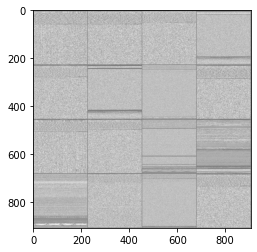

In [14]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [15]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224*224, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 224*224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
# loss값이 안줄면 sigmoid함수를 제거하고 BCE with Logits Loss를 사용해볼까?
# https://nuguziii.github.io/dev/dev-002/

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224*224))
        z = self.reparameterize(mu, logvar)  # z's shape => (batch_size, 100)
        return self.decode(z), mu, logvar, z

In [16]:
model = VAE().to(device)
print(model)

VAE(
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=100, bias=True)
  (fc22): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=50176, bias=True)
)


In [17]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [18]:
get_n_params(model)  

100704376

*Note*<br>
1-milion params.... it is so huge...

In [19]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

# PATH = '/Again_original_Exp01_200-Epoch.pth'

PATH = 'Epochs.pth'
# latent_vector = np.zeros((16, 100))
color_palette = np.zeros((1868))


In [21]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224*224), reduction='sum')  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    # latent_vector = np.zeros(())
    # latent_label = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z= model(data)
    
       
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
   
def test(epoch):
    # 10 Epoch 단위로 작업
    # model.state_dict() 저장 및 latent_vector 저장
    # plot latent vector
    if epoch % 10 == 0:  # Epoch이 10의 배수일때
     # save model.state_dict() per 10 Epochs
        torch.save(model.state_dict(), ('./Exp05_results/model_save_' + str(epoch) + PATH))  # Epoch 단위 parameter 저장

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 224, 224)[:n]])
                    save_image(comparison.cpu(),
                            './Exp05_results/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        Epoch_Loss['test_epoch'].append(epoch)
        Epoch_Loss['test_loss'].append(test_loss)

        # save latent vector's every 10 Epoch's
        # load_whole test_data 
        for i, (data, _) in enumerate(test_loader_10):  # load_whole test_data
            data = data.to(device)
            recon_batch, mu, logvar, z = model(data)
        # save latent_vector per 10 Epochs
            latent_vector = z.detach().cpu().clone().numpy()  # change tensor type data to cpu().numpy()
                                                              # latent_vector_size: (num_of_data, 100)
            color_palette = _.detach().cpu().clone().numpy()
            with open(('./Exp05_results/'+str(epoch)+'Epoch_z_vector.npy'), 'wb') as f:
                np.save(f, latent_vector)  # but latent vector size is (16, 100).... just 16...
                                           # 10 Epoch 단위로 latent vector를 저장한다
                                           # 이 떄, latent vector의 size는 test_dataset의 크기가 되어야 한다
                                           # 결과값이 좋은 vector는 좋은 feature로 사용할 수 있다.
        # plot latent vector Every 10 Epochs
        # t-SNE for Dimensionality reduction
        Z_embedded = TSNE(n_components=2).fit_transform(latent_vector)
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

        x = Z_embedded[:, 0]
        y = Z_embedded[:, 1]
        label = color_palette
        # label[10:12] = 0  # make sure there are some 0 values to show up as grey
        print("=="*20, "params", "=="*20)
        print("Z_embedded.shape:", Z_embedded.shape)
        print("label.shape:", label.shape)
        # tsne_data = np.vstack((Z_embedded, label))
        tsne_data = np.c_[Z_embedded, label]
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
        sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
        plt.savefig('./Exp05_results/plot_latent_vector/' + str(epoch) + '_t_SNE.png', dpi=300)
        plt.show()

    elif epoch % 10 !=0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 224, 224)[:n]])
                    save_image(comparison.cpu(),
                            './Exp05_results/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        Epoch_Loss['test_epoch'].append(epoch)
        Epoch_Loss['test_loss'].append(test_loss)

*Notice*<br>
Train Again!<br>
Change BCE loss param_reduction to 'sum'

1
Train Epoch: 1 [0/7471 (0%)]	Loss: 35166.972656
Train Epoch: 1 [160/7471 (2%)]	Loss: 38838.363281
Train Epoch: 1 [320/7471 (4%)]	Loss: 38954.703125
Train Epoch: 1 [480/7471 (6%)]	Loss: 36728.664062
Train Epoch: 1 [640/7471 (9%)]	Loss: 36050.425781
Train Epoch: 1 [800/7471 (11%)]	Loss: 36027.699219
Train Epoch: 1 [960/7471 (13%)]	Loss: 38284.054688
Train Epoch: 1 [1120/7471 (15%)]	Loss: 37185.890625
Train Epoch: 1 [1280/7471 (17%)]	Loss: 37304.320312
Train Epoch: 1 [1440/7471 (19%)]	Loss: 36355.203125
Train Epoch: 1 [1600/7471 (21%)]	Loss: 38258.566406
Train Epoch: 1 [1760/7471 (24%)]	Loss: 36525.925781
Train Epoch: 1 [1920/7471 (26%)]	Loss: 36073.140625
Train Epoch: 1 [2080/7471 (28%)]	Loss: 35152.242188
Train Epoch: 1 [2240/7471 (30%)]	Loss: 35118.691406
Train Epoch: 1 [2400/7471 (32%)]	Loss: 35774.675781
Train Epoch: 1 [2560/7471 (34%)]	Loss: 35772.851562
Train Epoch: 1 [2720/7471 (36%)]	Loss: 36102.398438
Train Epoch: 1 [2880/7471 (39%)]	Loss: 35083.007812
Train Epoch: 1 [3040/747

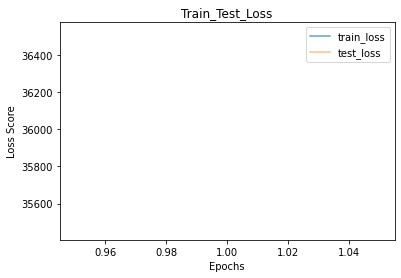

2
Train Epoch: 2 [0/7471 (0%)]	Loss: 35154.417969
Train Epoch: 2 [160/7471 (2%)]	Loss: 35467.738281
Train Epoch: 2 [320/7471 (4%)]	Loss: 33757.792969
Train Epoch: 2 [480/7471 (6%)]	Loss: 35196.906250
Train Epoch: 2 [640/7471 (9%)]	Loss: 35058.382812
Train Epoch: 2 [800/7471 (11%)]	Loss: 34299.964844
Train Epoch: 2 [960/7471 (13%)]	Loss: 34866.761719
Train Epoch: 2 [1120/7471 (15%)]	Loss: 36537.011719
Train Epoch: 2 [1280/7471 (17%)]	Loss: 37736.648438
Train Epoch: 2 [1440/7471 (19%)]	Loss: 36887.929688
Train Epoch: 2 [1600/7471 (21%)]	Loss: 35175.414062
Train Epoch: 2 [1760/7471 (24%)]	Loss: 33923.949219
Train Epoch: 2 [1920/7471 (26%)]	Loss: 36140.812500
Train Epoch: 2 [2080/7471 (28%)]	Loss: 35368.210938
Train Epoch: 2 [2240/7471 (30%)]	Loss: 34355.628906
Train Epoch: 2 [2400/7471 (32%)]	Loss: 33172.445312
Train Epoch: 2 [2560/7471 (34%)]	Loss: 34746.167969
Train Epoch: 2 [2720/7471 (36%)]	Loss: 34353.378906
Train Epoch: 2 [2880/7471 (39%)]	Loss: 34528.507812
Train Epoch: 2 [3040/747

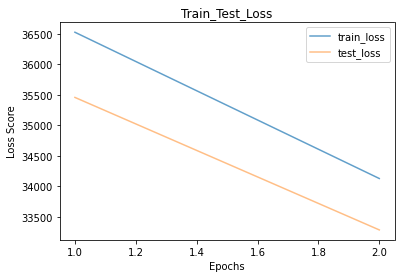

3
Train Epoch: 3 [0/7471 (0%)]	Loss: 34334.371094
Train Epoch: 3 [160/7471 (2%)]	Loss: 32276.435547
Train Epoch: 3 [320/7471 (4%)]	Loss: 31736.306641
Train Epoch: 3 [480/7471 (6%)]	Loss: 34582.066406
Train Epoch: 3 [640/7471 (9%)]	Loss: 33024.445312
Train Epoch: 3 [800/7471 (11%)]	Loss: 33273.363281
Train Epoch: 3 [960/7471 (13%)]	Loss: 32579.681641
Train Epoch: 3 [1120/7471 (15%)]	Loss: 32630.060547
Train Epoch: 3 [1280/7471 (17%)]	Loss: 33970.304688
Train Epoch: 3 [1440/7471 (19%)]	Loss: 34158.089844
Train Epoch: 3 [1600/7471 (21%)]	Loss: 34102.066406
Train Epoch: 3 [1760/7471 (24%)]	Loss: 33995.285156
Train Epoch: 3 [1920/7471 (26%)]	Loss: 32198.126953
Train Epoch: 3 [2080/7471 (28%)]	Loss: 33421.039062
Train Epoch: 3 [2240/7471 (30%)]	Loss: 33930.085938
Train Epoch: 3 [2400/7471 (32%)]	Loss: 32725.335938
Train Epoch: 3 [2560/7471 (34%)]	Loss: 33558.734375
Train Epoch: 3 [2720/7471 (36%)]	Loss: 32572.072266
Train Epoch: 3 [2880/7471 (39%)]	Loss: 33887.343750
Train Epoch: 3 [3040/747

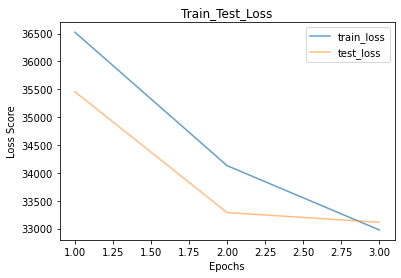

4
Train Epoch: 4 [0/7471 (0%)]	Loss: 33570.601562
Train Epoch: 4 [160/7471 (2%)]	Loss: 32639.662109
Train Epoch: 4 [320/7471 (4%)]	Loss: 33284.859375
Train Epoch: 4 [480/7471 (6%)]	Loss: 33255.941406
Train Epoch: 4 [640/7471 (9%)]	Loss: 32350.863281
Train Epoch: 4 [800/7471 (11%)]	Loss: 33132.554688
Train Epoch: 4 [960/7471 (13%)]	Loss: 31750.269531
Train Epoch: 4 [1120/7471 (15%)]	Loss: 31983.824219
Train Epoch: 4 [1280/7471 (17%)]	Loss: 32974.085938
Train Epoch: 4 [1440/7471 (19%)]	Loss: 33636.304688
Train Epoch: 4 [1600/7471 (21%)]	Loss: 31912.734375
Train Epoch: 4 [1760/7471 (24%)]	Loss: 32952.863281
Train Epoch: 4 [1920/7471 (26%)]	Loss: 33037.722656
Train Epoch: 4 [2080/7471 (28%)]	Loss: 31565.986328
Train Epoch: 4 [2240/7471 (30%)]	Loss: 33289.308594
Train Epoch: 4 [2400/7471 (32%)]	Loss: 31948.697266
Train Epoch: 4 [2560/7471 (34%)]	Loss: 32305.123047
Train Epoch: 4 [2720/7471 (36%)]	Loss: 33189.871094
Train Epoch: 4 [2880/7471 (39%)]	Loss: 32787.515625
Train Epoch: 4 [3040/747

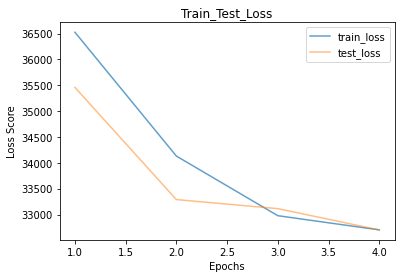

5
Train Epoch: 5 [0/7471 (0%)]	Loss: 33104.519531
Train Epoch: 5 [160/7471 (2%)]	Loss: 32187.427734
Train Epoch: 5 [320/7471 (4%)]	Loss: 33064.179688
Train Epoch: 5 [480/7471 (6%)]	Loss: 31887.556641
Train Epoch: 5 [640/7471 (9%)]	Loss: 33637.226562
Train Epoch: 5 [800/7471 (11%)]	Loss: 32053.820312
Train Epoch: 5 [960/7471 (13%)]	Loss: 33893.351562
Train Epoch: 5 [1120/7471 (15%)]	Loss: 33286.058594
Train Epoch: 5 [1280/7471 (17%)]	Loss: 32908.871094
Train Epoch: 5 [1440/7471 (19%)]	Loss: 33293.996094
Train Epoch: 5 [1600/7471 (21%)]	Loss: 31895.722656
Train Epoch: 5 [1760/7471 (24%)]	Loss: 32385.099609
Train Epoch: 5 [1920/7471 (26%)]	Loss: 33857.226562
Train Epoch: 5 [2080/7471 (28%)]	Loss: 33351.214844
Train Epoch: 5 [2240/7471 (30%)]	Loss: 31635.003906
Train Epoch: 5 [2400/7471 (32%)]	Loss: 33211.617188
Train Epoch: 5 [2560/7471 (34%)]	Loss: 32017.156250
Train Epoch: 5 [2720/7471 (36%)]	Loss: 32874.824219
Train Epoch: 5 [2880/7471 (39%)]	Loss: 32225.753906
Train Epoch: 5 [3040/747

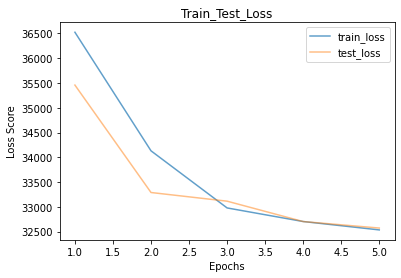

6
Train Epoch: 6 [0/7471 (0%)]	Loss: 32952.968750
Train Epoch: 6 [160/7471 (2%)]	Loss: 33093.414062
Train Epoch: 6 [320/7471 (4%)]	Loss: 33881.875000
Train Epoch: 6 [480/7471 (6%)]	Loss: 31626.691406
Train Epoch: 6 [640/7471 (9%)]	Loss: 33795.910156
Train Epoch: 6 [800/7471 (11%)]	Loss: 31238.724609
Train Epoch: 6 [960/7471 (13%)]	Loss: 32855.660156
Train Epoch: 6 [1120/7471 (15%)]	Loss: 33720.382812
Train Epoch: 6 [1280/7471 (17%)]	Loss: 29056.976562
Train Epoch: 6 [1440/7471 (19%)]	Loss: 33218.746094
Train Epoch: 6 [1600/7471 (21%)]	Loss: 33059.898438
Train Epoch: 6 [1760/7471 (24%)]	Loss: 32951.824219
Train Epoch: 6 [1920/7471 (26%)]	Loss: 31942.207031
Train Epoch: 6 [2080/7471 (28%)]	Loss: 31870.093750
Train Epoch: 6 [2240/7471 (30%)]	Loss: 31766.150391
Train Epoch: 6 [2400/7471 (32%)]	Loss: 31937.947266
Train Epoch: 6 [2560/7471 (34%)]	Loss: 32145.048828
Train Epoch: 6 [2720/7471 (36%)]	Loss: 33372.949219
Train Epoch: 6 [2880/7471 (39%)]	Loss: 32889.277344
Train Epoch: 6 [3040/747

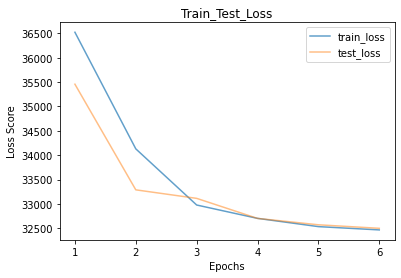

7
Train Epoch: 7 [0/7471 (0%)]	Loss: 34064.960938
Train Epoch: 7 [160/7471 (2%)]	Loss: 33351.078125
Train Epoch: 7 [320/7471 (4%)]	Loss: 33072.765625
Train Epoch: 7 [480/7471 (6%)]	Loss: 32210.712891
Train Epoch: 7 [640/7471 (9%)]	Loss: 33206.113281
Train Epoch: 7 [800/7471 (11%)]	Loss: 32630.347656
Train Epoch: 7 [960/7471 (13%)]	Loss: 32118.595703
Train Epoch: 7 [1120/7471 (15%)]	Loss: 32401.585938
Train Epoch: 7 [1280/7471 (17%)]	Loss: 33282.125000
Train Epoch: 7 [1440/7471 (19%)]	Loss: 32949.578125
Train Epoch: 7 [1600/7471 (21%)]	Loss: 32111.802734
Train Epoch: 7 [1760/7471 (24%)]	Loss: 32791.476562
Train Epoch: 7 [1920/7471 (26%)]	Loss: 33592.457031
Train Epoch: 7 [2080/7471 (28%)]	Loss: 32256.314453
Train Epoch: 7 [2240/7471 (30%)]	Loss: 32388.664062
Train Epoch: 7 [2400/7471 (32%)]	Loss: 33014.167969
Train Epoch: 7 [2560/7471 (34%)]	Loss: 32253.197266
Train Epoch: 7 [2720/7471 (36%)]	Loss: 30837.945312
Train Epoch: 7 [2880/7471 (39%)]	Loss: 30659.869141
Train Epoch: 7 [3040/747

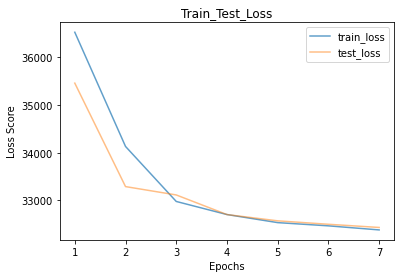

8
Train Epoch: 8 [0/7471 (0%)]	Loss: 32415.935547
Train Epoch: 8 [160/7471 (2%)]	Loss: 32851.269531
Train Epoch: 8 [320/7471 (4%)]	Loss: 29220.064453
Train Epoch: 8 [480/7471 (6%)]	Loss: 32978.476562
Train Epoch: 8 [640/7471 (9%)]	Loss: 33559.765625
Train Epoch: 8 [800/7471 (11%)]	Loss: 33045.375000
Train Epoch: 8 [960/7471 (13%)]	Loss: 32737.710938
Train Epoch: 8 [1120/7471 (15%)]	Loss: 33455.949219
Train Epoch: 8 [1280/7471 (17%)]	Loss: 32112.695312
Train Epoch: 8 [1440/7471 (19%)]	Loss: 33366.781250
Train Epoch: 8 [1600/7471 (21%)]	Loss: 33508.812500
Train Epoch: 8 [1760/7471 (24%)]	Loss: 32954.757812
Train Epoch: 8 [1920/7471 (26%)]	Loss: 33127.296875
Train Epoch: 8 [2080/7471 (28%)]	Loss: 32657.503906
Train Epoch: 8 [2240/7471 (30%)]	Loss: 32407.882812
Train Epoch: 8 [2400/7471 (32%)]	Loss: 32544.394531
Train Epoch: 8 [2560/7471 (34%)]	Loss: 32509.429688
Train Epoch: 8 [2720/7471 (36%)]	Loss: 32410.552734
Train Epoch: 8 [2880/7471 (39%)]	Loss: 33672.816406
Train Epoch: 8 [3040/747

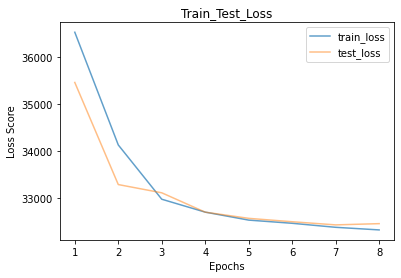

9
Train Epoch: 9 [0/7471 (0%)]	Loss: 32102.208984
Train Epoch: 9 [160/7471 (2%)]	Loss: 33226.328125
Train Epoch: 9 [320/7471 (4%)]	Loss: 33699.996094
Train Epoch: 9 [480/7471 (6%)]	Loss: 31523.017578
Train Epoch: 9 [640/7471 (9%)]	Loss: 33629.988281
Train Epoch: 9 [800/7471 (11%)]	Loss: 33006.609375
Train Epoch: 9 [960/7471 (13%)]	Loss: 31582.501953
Train Epoch: 9 [1120/7471 (15%)]	Loss: 30762.572266
Train Epoch: 9 [1280/7471 (17%)]	Loss: 33146.757812
Train Epoch: 9 [1440/7471 (19%)]	Loss: 32551.474609
Train Epoch: 9 [1600/7471 (21%)]	Loss: 32941.808594
Train Epoch: 9 [1760/7471 (24%)]	Loss: 30958.246094
Train Epoch: 9 [1920/7471 (26%)]	Loss: 32609.826172
Train Epoch: 9 [2080/7471 (28%)]	Loss: 32245.308594
Train Epoch: 9 [2240/7471 (30%)]	Loss: 32244.984375
Train Epoch: 9 [2400/7471 (32%)]	Loss: 33409.812500
Train Epoch: 9 [2560/7471 (34%)]	Loss: 32179.699219
Train Epoch: 9 [2720/7471 (36%)]	Loss: 32090.833984
Train Epoch: 9 [2880/7471 (39%)]	Loss: 33232.386719
Train Epoch: 9 [3040/747

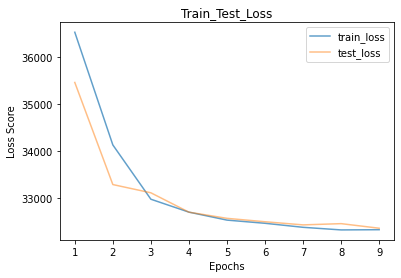

10
Train Epoch: 10 [0/7471 (0%)]	Loss: 33035.972656
Train Epoch: 10 [160/7471 (2%)]	Loss: 33335.640625
Train Epoch: 10 [320/7471 (4%)]	Loss: 31458.439453
Train Epoch: 10 [480/7471 (6%)]	Loss: 31671.232422
Train Epoch: 10 [640/7471 (9%)]	Loss: 32975.683594
Train Epoch: 10 [800/7471 (11%)]	Loss: 32569.484375
Train Epoch: 10 [960/7471 (13%)]	Loss: 33845.523438
Train Epoch: 10 [1120/7471 (15%)]	Loss: 30709.232422
Train Epoch: 10 [1280/7471 (17%)]	Loss: 33254.242188
Train Epoch: 10 [1440/7471 (19%)]	Loss: 33211.628906
Train Epoch: 10 [1600/7471 (21%)]	Loss: 32449.904297
Train Epoch: 10 [1760/7471 (24%)]	Loss: 32336.017578
Train Epoch: 10 [1920/7471 (26%)]	Loss: 33246.355469
Train Epoch: 10 [2080/7471 (28%)]	Loss: 33791.082031
Train Epoch: 10 [2240/7471 (30%)]	Loss: 32825.425781
Train Epoch: 10 [2400/7471 (32%)]	Loss: 32089.904297
Train Epoch: 10 [2560/7471 (34%)]	Loss: 32387.644531
Train Epoch: 10 [2720/7471 (36%)]	Loss: 32168.154297
Train Epoch: 10 [2880/7471 (39%)]	Loss: 33450.910156
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


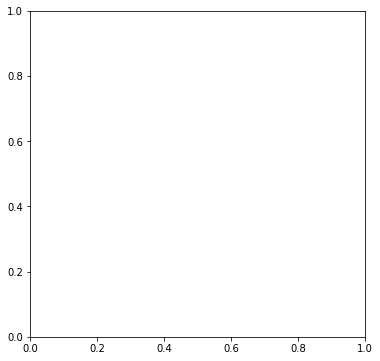

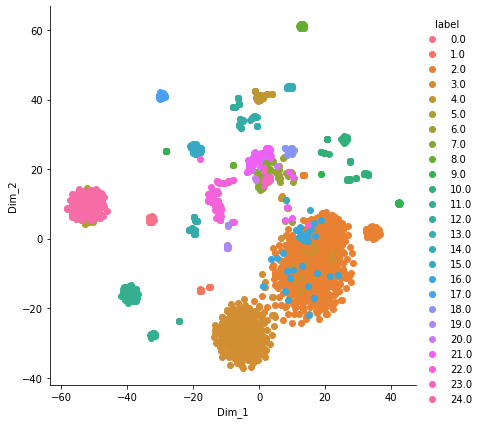

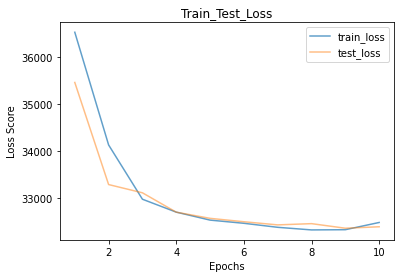

11
Train Epoch: 11 [0/7471 (0%)]	Loss: 33545.808594
Train Epoch: 11 [160/7471 (2%)]	Loss: 31797.142578
Train Epoch: 11 [320/7471 (4%)]	Loss: 33433.898438
Train Epoch: 11 [480/7471 (6%)]	Loss: 31566.781250
Train Epoch: 11 [640/7471 (9%)]	Loss: 33192.714844
Train Epoch: 11 [800/7471 (11%)]	Loss: 32202.937500
Train Epoch: 11 [960/7471 (13%)]	Loss: 32853.003906
Train Epoch: 11 [1120/7471 (15%)]	Loss: 32774.421875
Train Epoch: 11 [1280/7471 (17%)]	Loss: 31700.111328
Train Epoch: 11 [1440/7471 (19%)]	Loss: 30520.154297
Train Epoch: 11 [1600/7471 (21%)]	Loss: 32484.339844
Train Epoch: 11 [1760/7471 (24%)]	Loss: 33244.875000
Train Epoch: 11 [1920/7471 (26%)]	Loss: 31848.265625
Train Epoch: 11 [2080/7471 (28%)]	Loss: 33068.406250
Train Epoch: 11 [2240/7471 (30%)]	Loss: 32370.708984
Train Epoch: 11 [2400/7471 (32%)]	Loss: 32093.050781
Train Epoch: 11 [2560/7471 (34%)]	Loss: 29406.755859
Train Epoch: 11 [2720/7471 (36%)]	Loss: 33516.207031
Train Epoch: 11 [2880/7471 (39%)]	Loss: 33577.511719
Trai

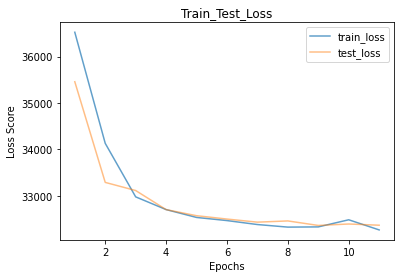

12
Train Epoch: 12 [0/7471 (0%)]	Loss: 32237.291016
Train Epoch: 12 [160/7471 (2%)]	Loss: 32774.500000
Train Epoch: 12 [320/7471 (4%)]	Loss: 31294.558594
Train Epoch: 12 [480/7471 (6%)]	Loss: 32264.796875
Train Epoch: 12 [640/7471 (9%)]	Loss: 31934.683594
Train Epoch: 12 [800/7471 (11%)]	Loss: 32803.960938
Train Epoch: 12 [960/7471 (13%)]	Loss: 32676.058594
Train Epoch: 12 [1120/7471 (15%)]	Loss: 32118.183594
Train Epoch: 12 [1280/7471 (17%)]	Loss: 33304.687500
Train Epoch: 12 [1440/7471 (19%)]	Loss: 33777.417969
Train Epoch: 12 [1600/7471 (21%)]	Loss: 31551.322266
Train Epoch: 12 [1760/7471 (24%)]	Loss: 30821.789062
Train Epoch: 12 [1920/7471 (26%)]	Loss: 30898.539062
Train Epoch: 12 [2080/7471 (28%)]	Loss: 33183.582031
Train Epoch: 12 [2240/7471 (30%)]	Loss: 31922.199219
Train Epoch: 12 [2400/7471 (32%)]	Loss: 31075.275391
Train Epoch: 12 [2560/7471 (34%)]	Loss: 32343.826172
Train Epoch: 12 [2720/7471 (36%)]	Loss: 32432.119141
Train Epoch: 12 [2880/7471 (39%)]	Loss: 31826.541016
Trai

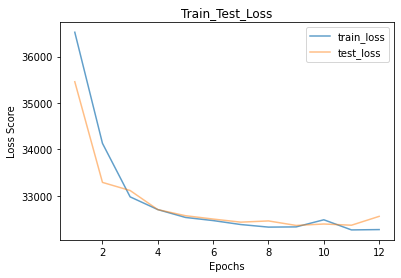

13
Train Epoch: 13 [0/7471 (0%)]	Loss: 33691.902344
Train Epoch: 13 [160/7471 (2%)]	Loss: 33481.750000
Train Epoch: 13 [320/7471 (4%)]	Loss: 31600.039062
Train Epoch: 13 [480/7471 (6%)]	Loss: 31774.121094
Train Epoch: 13 [640/7471 (9%)]	Loss: 32242.443359
Train Epoch: 13 [800/7471 (11%)]	Loss: 32958.460938
Train Epoch: 13 [960/7471 (13%)]	Loss: 33334.609375
Train Epoch: 13 [1120/7471 (15%)]	Loss: 33981.804688
Train Epoch: 13 [1280/7471 (17%)]	Loss: 33537.476562
Train Epoch: 13 [1440/7471 (19%)]	Loss: 31998.802734
Train Epoch: 13 [1600/7471 (21%)]	Loss: 33368.421875
Train Epoch: 13 [1760/7471 (24%)]	Loss: 33296.347656
Train Epoch: 13 [1920/7471 (26%)]	Loss: 34003.144531
Train Epoch: 13 [2080/7471 (28%)]	Loss: 33706.851562
Train Epoch: 13 [2240/7471 (30%)]	Loss: 33068.746094
Train Epoch: 13 [2400/7471 (32%)]	Loss: 32217.175781
Train Epoch: 13 [2560/7471 (34%)]	Loss: 33676.339844
Train Epoch: 13 [2720/7471 (36%)]	Loss: 33065.621094
Train Epoch: 13 [2880/7471 (39%)]	Loss: 33666.589844
Trai

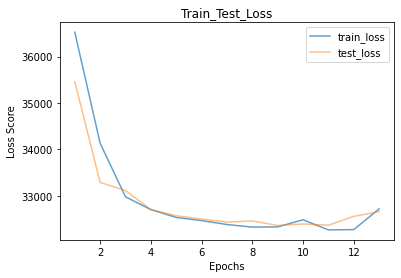

14
Train Epoch: 14 [0/7471 (0%)]	Loss: 32489.482422
Train Epoch: 14 [160/7471 (2%)]	Loss: 32655.242188
Train Epoch: 14 [320/7471 (4%)]	Loss: 32825.507812
Train Epoch: 14 [480/7471 (6%)]	Loss: 31911.748047
Train Epoch: 14 [640/7471 (9%)]	Loss: 31397.718750
Train Epoch: 14 [800/7471 (11%)]	Loss: 31205.113281
Train Epoch: 14 [960/7471 (13%)]	Loss: 32275.152344
Train Epoch: 14 [1120/7471 (15%)]	Loss: 33563.050781
Train Epoch: 14 [1280/7471 (17%)]	Loss: 33397.203125
Train Epoch: 14 [1440/7471 (19%)]	Loss: 32372.164062
Train Epoch: 14 [1600/7471 (21%)]	Loss: 31050.070312
Train Epoch: 14 [1760/7471 (24%)]	Loss: 32273.449219
Train Epoch: 14 [1920/7471 (26%)]	Loss: 31435.712891
Train Epoch: 14 [2080/7471 (28%)]	Loss: 30818.365234
Train Epoch: 14 [2240/7471 (30%)]	Loss: 33436.347656
Train Epoch: 14 [2400/7471 (32%)]	Loss: 32444.777344
Train Epoch: 14 [2560/7471 (34%)]	Loss: 29064.544922
Train Epoch: 14 [2720/7471 (36%)]	Loss: 32537.970703
Train Epoch: 14 [2880/7471 (39%)]	Loss: 31837.306641
Trai

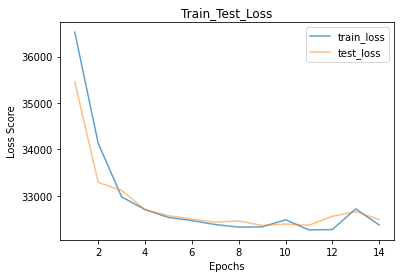

15
Train Epoch: 15 [0/7471 (0%)]	Loss: 31666.277344
Train Epoch: 15 [160/7471 (2%)]	Loss: 33173.890625
Train Epoch: 15 [320/7471 (4%)]	Loss: 32409.005859
Train Epoch: 15 [480/7471 (6%)]	Loss: 31837.939453
Train Epoch: 15 [640/7471 (9%)]	Loss: 32031.429688
Train Epoch: 15 [800/7471 (11%)]	Loss: 32289.042969
Train Epoch: 15 [960/7471 (13%)]	Loss: 30134.085938
Train Epoch: 15 [1120/7471 (15%)]	Loss: 32835.867188
Train Epoch: 15 [1280/7471 (17%)]	Loss: 32686.248047
Train Epoch: 15 [1440/7471 (19%)]	Loss: 31747.224609
Train Epoch: 15 [1600/7471 (21%)]	Loss: 33426.476562
Train Epoch: 15 [1760/7471 (24%)]	Loss: 32091.050781
Train Epoch: 15 [1920/7471 (26%)]	Loss: 33434.144531
Train Epoch: 15 [2080/7471 (28%)]	Loss: 32565.187500
Train Epoch: 15 [2240/7471 (30%)]	Loss: 33446.246094
Train Epoch: 15 [2400/7471 (32%)]	Loss: 30548.673828
Train Epoch: 15 [2560/7471 (34%)]	Loss: 31844.798828
Train Epoch: 15 [2720/7471 (36%)]	Loss: 30936.726562
Train Epoch: 15 [2880/7471 (39%)]	Loss: 31352.562500
Trai

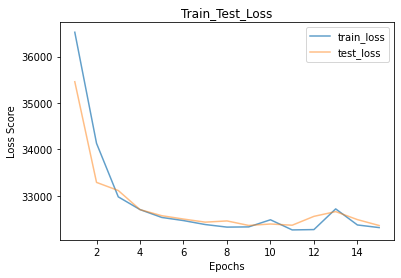

16
Train Epoch: 16 [0/7471 (0%)]	Loss: 31616.076172
Train Epoch: 16 [160/7471 (2%)]	Loss: 31470.402344
Train Epoch: 16 [320/7471 (4%)]	Loss: 32125.904297
Train Epoch: 16 [480/7471 (6%)]	Loss: 31441.751953
Train Epoch: 16 [640/7471 (9%)]	Loss: 31819.582031
Train Epoch: 16 [800/7471 (11%)]	Loss: 30439.021484
Train Epoch: 16 [960/7471 (13%)]	Loss: 31624.494141
Train Epoch: 16 [1120/7471 (15%)]	Loss: 32661.134766
Train Epoch: 16 [1280/7471 (17%)]	Loss: 32514.207031
Train Epoch: 16 [1440/7471 (19%)]	Loss: 31159.505859
Train Epoch: 16 [1600/7471 (21%)]	Loss: 30084.964844
Train Epoch: 16 [1760/7471 (24%)]	Loss: 32905.210938
Train Epoch: 16 [1920/7471 (26%)]	Loss: 33186.777344
Train Epoch: 16 [2080/7471 (28%)]	Loss: 33031.226562
Train Epoch: 16 [2240/7471 (30%)]	Loss: 32639.328125
Train Epoch: 16 [2400/7471 (32%)]	Loss: 32949.792969
Train Epoch: 16 [2560/7471 (34%)]	Loss: 31886.039062
Train Epoch: 16 [2720/7471 (36%)]	Loss: 32656.855469
Train Epoch: 16 [2880/7471 (39%)]	Loss: 32911.917969
Trai

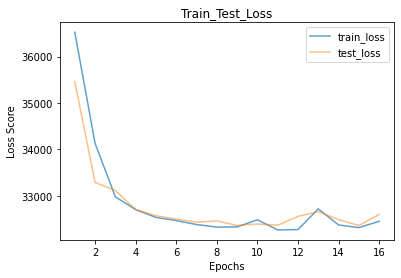

17
Train Epoch: 17 [0/7471 (0%)]	Loss: 32382.955078
Train Epoch: 17 [160/7471 (2%)]	Loss: 33225.054688
Train Epoch: 17 [320/7471 (4%)]	Loss: 30845.386719
Train Epoch: 17 [480/7471 (6%)]	Loss: 31335.378906
Train Epoch: 17 [640/7471 (9%)]	Loss: 32088.843750
Train Epoch: 17 [800/7471 (11%)]	Loss: 32771.968750
Train Epoch: 17 [960/7471 (13%)]	Loss: 32204.931641
Train Epoch: 17 [1120/7471 (15%)]	Loss: 34393.054688
Train Epoch: 17 [1280/7471 (17%)]	Loss: 32987.761719
Train Epoch: 17 [1440/7471 (19%)]	Loss: 33367.207031
Train Epoch: 17 [1600/7471 (21%)]	Loss: 33417.046875
Train Epoch: 17 [1760/7471 (24%)]	Loss: 33711.851562
Train Epoch: 17 [1920/7471 (26%)]	Loss: 33497.921875
Train Epoch: 17 [2080/7471 (28%)]	Loss: 33443.761719
Train Epoch: 17 [2240/7471 (30%)]	Loss: 32563.574219
Train Epoch: 17 [2400/7471 (32%)]	Loss: 31389.335938
Train Epoch: 17 [2560/7471 (34%)]	Loss: 32526.828125
Train Epoch: 17 [2720/7471 (36%)]	Loss: 31307.041016
Train Epoch: 17 [2880/7471 (39%)]	Loss: 30057.251953
Trai

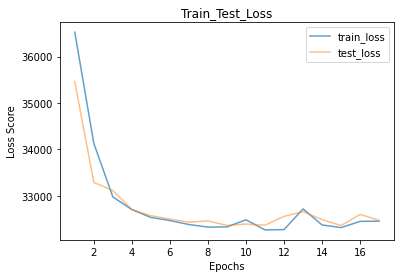

18
Train Epoch: 18 [0/7471 (0%)]	Loss: 32901.156250
Train Epoch: 18 [160/7471 (2%)]	Loss: 30830.296875
Train Epoch: 18 [320/7471 (4%)]	Loss: 33710.257812
Train Epoch: 18 [480/7471 (6%)]	Loss: 31707.511719
Train Epoch: 18 [640/7471 (9%)]	Loss: 32096.736328
Train Epoch: 18 [800/7471 (11%)]	Loss: 31304.185547
Train Epoch: 18 [960/7471 (13%)]	Loss: 33070.207031
Train Epoch: 18 [1120/7471 (15%)]	Loss: 33330.550781
Train Epoch: 18 [1280/7471 (17%)]	Loss: 31454.537109
Train Epoch: 18 [1440/7471 (19%)]	Loss: 32924.902344
Train Epoch: 18 [1600/7471 (21%)]	Loss: 32320.298828
Train Epoch: 18 [1760/7471 (24%)]	Loss: 33147.074219
Train Epoch: 18 [1920/7471 (26%)]	Loss: 32709.583984
Train Epoch: 18 [2080/7471 (28%)]	Loss: 31704.103516
Train Epoch: 18 [2240/7471 (30%)]	Loss: 32100.068359
Train Epoch: 18 [2400/7471 (32%)]	Loss: 31860.664062
Train Epoch: 18 [2560/7471 (34%)]	Loss: 32879.187500
Train Epoch: 18 [2720/7471 (36%)]	Loss: 33371.343750
Train Epoch: 18 [2880/7471 (39%)]	Loss: 32083.517578
Trai

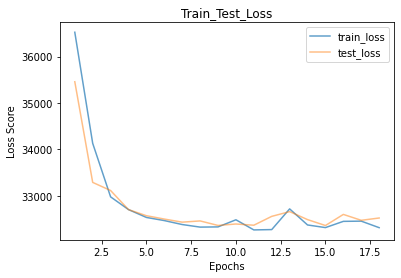

19
Train Epoch: 19 [0/7471 (0%)]	Loss: 33021.804688
Train Epoch: 19 [160/7471 (2%)]	Loss: 33010.324219
Train Epoch: 19 [320/7471 (4%)]	Loss: 32764.779297
Train Epoch: 19 [480/7471 (6%)]	Loss: 31983.644531
Train Epoch: 19 [640/7471 (9%)]	Loss: 32288.849609
Train Epoch: 19 [800/7471 (11%)]	Loss: 33502.425781
Train Epoch: 19 [960/7471 (13%)]	Loss: 31617.060547
Train Epoch: 19 [1120/7471 (15%)]	Loss: 33453.425781
Train Epoch: 19 [1280/7471 (17%)]	Loss: 32494.847656
Train Epoch: 19 [1440/7471 (19%)]	Loss: 33491.152344
Train Epoch: 19 [1600/7471 (21%)]	Loss: 31096.904297
Train Epoch: 19 [1760/7471 (24%)]	Loss: 31080.144531
Train Epoch: 19 [1920/7471 (26%)]	Loss: 31781.384766
Train Epoch: 19 [2080/7471 (28%)]	Loss: 33169.605469
Train Epoch: 19 [2240/7471 (30%)]	Loss: 33064.027344
Train Epoch: 19 [2400/7471 (32%)]	Loss: 33192.578125
Train Epoch: 19 [2560/7471 (34%)]	Loss: 32838.402344
Train Epoch: 19 [2720/7471 (36%)]	Loss: 32260.351562
Train Epoch: 19 [2880/7471 (39%)]	Loss: 32612.601562
Trai

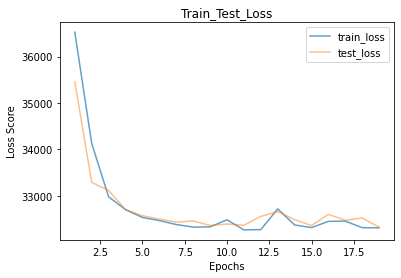

20
Train Epoch: 20 [0/7471 (0%)]	Loss: 33568.515625
Train Epoch: 20 [160/7471 (2%)]	Loss: 31029.970703
Train Epoch: 20 [320/7471 (4%)]	Loss: 31966.167969
Train Epoch: 20 [480/7471 (6%)]	Loss: 30954.246094
Train Epoch: 20 [640/7471 (9%)]	Loss: 32564.941406
Train Epoch: 20 [800/7471 (11%)]	Loss: 31811.080078
Train Epoch: 20 [960/7471 (13%)]	Loss: 31852.978516
Train Epoch: 20 [1120/7471 (15%)]	Loss: 33286.593750
Train Epoch: 20 [1280/7471 (17%)]	Loss: 32706.912109
Train Epoch: 20 [1440/7471 (19%)]	Loss: 33193.316406
Train Epoch: 20 [1600/7471 (21%)]	Loss: 32037.240234
Train Epoch: 20 [1760/7471 (24%)]	Loss: 32952.039062
Train Epoch: 20 [1920/7471 (26%)]	Loss: 32625.880859
Train Epoch: 20 [2080/7471 (28%)]	Loss: 31558.287109
Train Epoch: 20 [2240/7471 (30%)]	Loss: 31866.974609
Train Epoch: 20 [2400/7471 (32%)]	Loss: 33944.863281
Train Epoch: 20 [2560/7471 (34%)]	Loss: 33266.035156
Train Epoch: 20 [2720/7471 (36%)]	Loss: 33126.812500
Train Epoch: 20 [2880/7471 (39%)]	Loss: 33194.886719
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


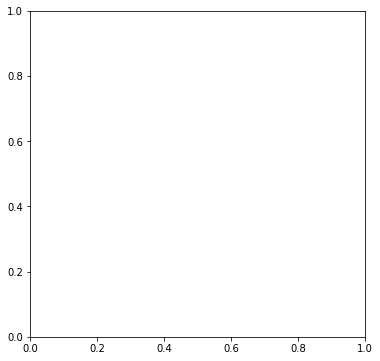

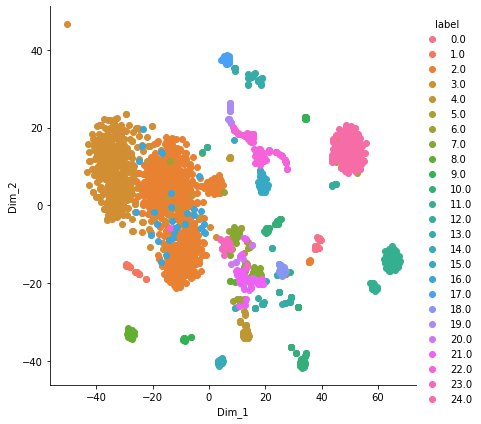

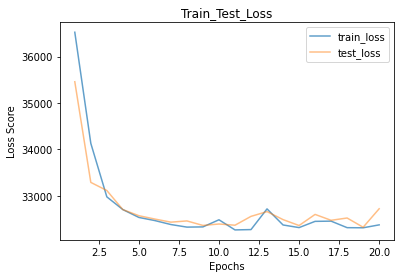

21
Train Epoch: 21 [0/7471 (0%)]	Loss: 31331.484375
Train Epoch: 21 [160/7471 (2%)]	Loss: 32498.171875
Train Epoch: 21 [320/7471 (4%)]	Loss: 30675.460938
Train Epoch: 21 [480/7471 (6%)]	Loss: 30986.703125
Train Epoch: 21 [640/7471 (9%)]	Loss: 33843.730469
Train Epoch: 21 [800/7471 (11%)]	Loss: 33011.835938
Train Epoch: 21 [960/7471 (13%)]	Loss: 33749.125000
Train Epoch: 21 [1120/7471 (15%)]	Loss: 33286.238281
Train Epoch: 21 [1280/7471 (17%)]	Loss: 33585.503906
Train Epoch: 21 [1440/7471 (19%)]	Loss: 33651.437500
Train Epoch: 21 [1600/7471 (21%)]	Loss: 32138.685547
Train Epoch: 21 [1760/7471 (24%)]	Loss: 32794.996094
Train Epoch: 21 [1920/7471 (26%)]	Loss: 34155.593750
Train Epoch: 21 [2080/7471 (28%)]	Loss: 32991.597656
Train Epoch: 21 [2240/7471 (30%)]	Loss: 33301.535156
Train Epoch: 21 [2400/7471 (32%)]	Loss: 32117.421875
Train Epoch: 21 [2560/7471 (34%)]	Loss: 33051.250000
Train Epoch: 21 [2720/7471 (36%)]	Loss: 33340.644531
Train Epoch: 21 [2880/7471 (39%)]	Loss: 33378.367188
Trai

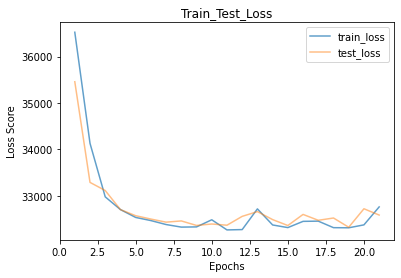

22
Train Epoch: 22 [0/7471 (0%)]	Loss: 33160.363281
Train Epoch: 22 [160/7471 (2%)]	Loss: 33241.980469
Train Epoch: 22 [320/7471 (4%)]	Loss: 33069.773438
Train Epoch: 22 [480/7471 (6%)]	Loss: 33006.093750
Train Epoch: 22 [640/7471 (9%)]	Loss: 33402.003906
Train Epoch: 22 [800/7471 (11%)]	Loss: 31413.326172
Train Epoch: 22 [960/7471 (13%)]	Loss: 32455.507812
Train Epoch: 22 [1120/7471 (15%)]	Loss: 31934.289062
Train Epoch: 22 [1280/7471 (17%)]	Loss: 32853.437500
Train Epoch: 22 [1440/7471 (19%)]	Loss: 31974.294922
Train Epoch: 22 [1600/7471 (21%)]	Loss: 33948.574219
Train Epoch: 22 [1760/7471 (24%)]	Loss: 33916.742188
Train Epoch: 22 [1920/7471 (26%)]	Loss: 32575.992188
Train Epoch: 22 [2080/7471 (28%)]	Loss: 34560.949219
Train Epoch: 22 [2240/7471 (30%)]	Loss: 33866.371094
Train Epoch: 22 [2400/7471 (32%)]	Loss: 34602.027344
Train Epoch: 22 [2560/7471 (34%)]	Loss: 33723.765625
Train Epoch: 22 [2720/7471 (36%)]	Loss: 34213.390625
Train Epoch: 22 [2880/7471 (39%)]	Loss: 33572.902344
Trai

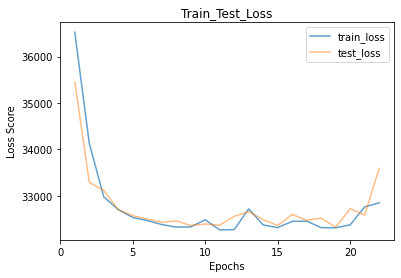

23
Train Epoch: 23 [0/7471 (0%)]	Loss: 32585.861328
Train Epoch: 23 [160/7471 (2%)]	Loss: 34409.707031
Train Epoch: 23 [320/7471 (4%)]	Loss: 33940.605469
Train Epoch: 23 [480/7471 (6%)]	Loss: 32039.802734
Train Epoch: 23 [640/7471 (9%)]	Loss: 33683.527344
Train Epoch: 23 [800/7471 (11%)]	Loss: 32586.363281
Train Epoch: 23 [960/7471 (13%)]	Loss: 33261.527344
Train Epoch: 23 [1120/7471 (15%)]	Loss: 31702.962891
Train Epoch: 23 [1280/7471 (17%)]	Loss: 32392.363281
Train Epoch: 23 [1440/7471 (19%)]	Loss: 32910.441406
Train Epoch: 23 [1600/7471 (21%)]	Loss: 31697.847656
Train Epoch: 23 [1760/7471 (24%)]	Loss: 33415.984375
Train Epoch: 23 [1920/7471 (26%)]	Loss: 30966.429688
Train Epoch: 23 [2080/7471 (28%)]	Loss: 32785.992188
Train Epoch: 23 [2240/7471 (30%)]	Loss: 33854.187500
Train Epoch: 23 [2400/7471 (32%)]	Loss: 31762.085938
Train Epoch: 23 [2560/7471 (34%)]	Loss: 31182.816406
Train Epoch: 23 [2720/7471 (36%)]	Loss: 32721.373047
Train Epoch: 23 [2880/7471 (39%)]	Loss: 33194.437500
Trai

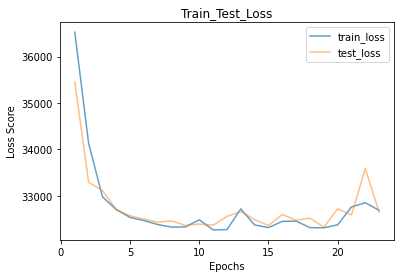

24
Train Epoch: 24 [0/7471 (0%)]	Loss: 32472.222656
Train Epoch: 24 [160/7471 (2%)]	Loss: 32959.632812
Train Epoch: 24 [320/7471 (4%)]	Loss: 32883.425781
Train Epoch: 24 [480/7471 (6%)]	Loss: 32355.501953
Train Epoch: 24 [640/7471 (9%)]	Loss: 31117.509766
Train Epoch: 24 [800/7471 (11%)]	Loss: 33489.023438
Train Epoch: 24 [960/7471 (13%)]	Loss: 33337.074219
Train Epoch: 24 [1120/7471 (15%)]	Loss: 31364.847656
Train Epoch: 24 [1280/7471 (17%)]	Loss: 32531.689453
Train Epoch: 24 [1440/7471 (19%)]	Loss: 38907.468750
Train Epoch: 24 [1600/7471 (21%)]	Loss: 32430.007812
Train Epoch: 24 [1760/7471 (24%)]	Loss: 33276.042969
Train Epoch: 24 [1920/7471 (26%)]	Loss: 29630.675781
Train Epoch: 24 [2080/7471 (28%)]	Loss: 32749.656250
Train Epoch: 24 [2240/7471 (30%)]	Loss: 31616.085938
Train Epoch: 24 [2400/7471 (32%)]	Loss: 31867.744141
Train Epoch: 24 [2560/7471 (34%)]	Loss: 32361.021484
Train Epoch: 24 [2720/7471 (36%)]	Loss: 32101.265625
Train Epoch: 24 [2880/7471 (39%)]	Loss: 32208.955078
Trai

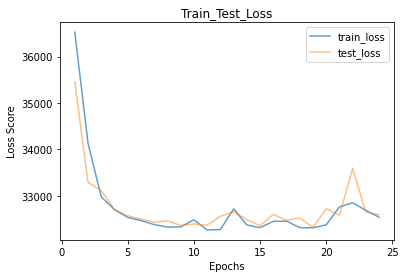

25
Train Epoch: 25 [0/7471 (0%)]	Loss: 33091.328125
Train Epoch: 25 [160/7471 (2%)]	Loss: 33598.550781
Train Epoch: 25 [320/7471 (4%)]	Loss: 32682.873047
Train Epoch: 25 [480/7471 (6%)]	Loss: 33604.199219
Train Epoch: 25 [640/7471 (9%)]	Loss: 32297.228516
Train Epoch: 25 [800/7471 (11%)]	Loss: 33507.738281
Train Epoch: 25 [960/7471 (13%)]	Loss: 33895.089844
Train Epoch: 25 [1120/7471 (15%)]	Loss: 34060.949219
Train Epoch: 25 [1280/7471 (17%)]	Loss: 33267.359375
Train Epoch: 25 [1440/7471 (19%)]	Loss: 31436.980469
Train Epoch: 25 [1600/7471 (21%)]	Loss: 34258.265625
Train Epoch: 25 [1760/7471 (24%)]	Loss: 34502.949219
Train Epoch: 25 [1920/7471 (26%)]	Loss: 35426.546875
Train Epoch: 25 [2080/7471 (28%)]	Loss: 32544.955078
Train Epoch: 25 [2240/7471 (30%)]	Loss: 33627.847656
Train Epoch: 25 [2400/7471 (32%)]	Loss: 32252.468750
Train Epoch: 25 [2560/7471 (34%)]	Loss: 32009.421875
Train Epoch: 25 [2720/7471 (36%)]	Loss: 32515.693359
Train Epoch: 25 [2880/7471 (39%)]	Loss: 33567.160156
Trai

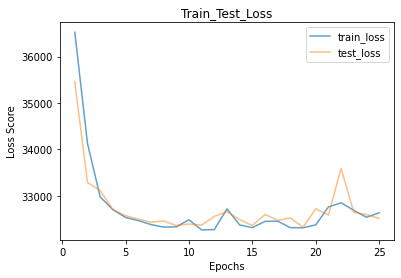

26
Train Epoch: 26 [0/7471 (0%)]	Loss: 32893.914062
Train Epoch: 26 [160/7471 (2%)]	Loss: 32243.214844
Train Epoch: 26 [320/7471 (4%)]	Loss: 31109.666016
Train Epoch: 26 [480/7471 (6%)]	Loss: 32142.982422
Train Epoch: 26 [640/7471 (9%)]	Loss: 32291.896484
Train Epoch: 26 [800/7471 (11%)]	Loss: 31449.845703
Train Epoch: 26 [960/7471 (13%)]	Loss: 33304.500000
Train Epoch: 26 [1120/7471 (15%)]	Loss: 33236.156250
Train Epoch: 26 [1280/7471 (17%)]	Loss: 33664.613281
Train Epoch: 26 [1440/7471 (19%)]	Loss: 32369.724609
Train Epoch: 26 [1600/7471 (21%)]	Loss: 32150.599609
Train Epoch: 26 [1760/7471 (24%)]	Loss: 32082.658203
Train Epoch: 26 [1920/7471 (26%)]	Loss: 32125.414062
Train Epoch: 26 [2080/7471 (28%)]	Loss: 31275.439453
Train Epoch: 26 [2240/7471 (30%)]	Loss: 32015.437500
Train Epoch: 26 [2400/7471 (32%)]	Loss: 33615.777344
Train Epoch: 26 [2560/7471 (34%)]	Loss: 32119.625000
Train Epoch: 26 [2720/7471 (36%)]	Loss: 33304.492188
Train Epoch: 26 [2880/7471 (39%)]	Loss: 31379.408203
Trai

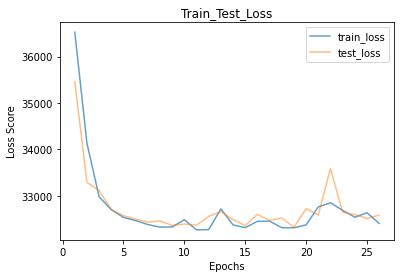

27
Train Epoch: 27 [0/7471 (0%)]	Loss: 33252.140625
Train Epoch: 27 [160/7471 (2%)]	Loss: 32478.462891
Train Epoch: 27 [320/7471 (4%)]	Loss: 33085.500000
Train Epoch: 27 [480/7471 (6%)]	Loss: 32622.917969
Train Epoch: 27 [640/7471 (9%)]	Loss: 33404.917969
Train Epoch: 27 [800/7471 (11%)]	Loss: 33739.968750
Train Epoch: 27 [960/7471 (13%)]	Loss: 30930.941406
Train Epoch: 27 [1120/7471 (15%)]	Loss: 31126.646484
Train Epoch: 27 [1280/7471 (17%)]	Loss: 33510.496094
Train Epoch: 27 [1440/7471 (19%)]	Loss: 33324.562500
Train Epoch: 27 [1600/7471 (21%)]	Loss: 33114.031250
Train Epoch: 27 [1760/7471 (24%)]	Loss: 32167.894531
Train Epoch: 27 [1920/7471 (26%)]	Loss: 32597.875000
Train Epoch: 27 [2080/7471 (28%)]	Loss: 32073.863281
Train Epoch: 27 [2240/7471 (30%)]	Loss: 33002.757812
Train Epoch: 27 [2400/7471 (32%)]	Loss: 32867.941406
Train Epoch: 27 [2560/7471 (34%)]	Loss: 33309.152344
Train Epoch: 27 [2720/7471 (36%)]	Loss: 33112.273438
Train Epoch: 27 [2880/7471 (39%)]	Loss: 33357.847656
Trai

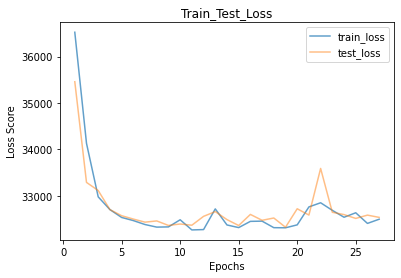

28
Train Epoch: 28 [0/7471 (0%)]	Loss: 31566.847656
Train Epoch: 28 [160/7471 (2%)]	Loss: 33935.921875
Train Epoch: 28 [320/7471 (4%)]	Loss: 32300.726562
Train Epoch: 28 [480/7471 (6%)]	Loss: 32968.996094
Train Epoch: 28 [640/7471 (9%)]	Loss: 31593.072266
Train Epoch: 28 [800/7471 (11%)]	Loss: 32848.496094
Train Epoch: 28 [960/7471 (13%)]	Loss: 31242.628906
Train Epoch: 28 [1120/7471 (15%)]	Loss: 31873.974609
Train Epoch: 28 [1280/7471 (17%)]	Loss: 31681.218750
Train Epoch: 28 [1440/7471 (19%)]	Loss: 31138.847656
Train Epoch: 28 [1600/7471 (21%)]	Loss: 33305.179688
Train Epoch: 28 [1760/7471 (24%)]	Loss: 31664.357422
Train Epoch: 28 [1920/7471 (26%)]	Loss: 32683.535156
Train Epoch: 28 [2080/7471 (28%)]	Loss: 34056.894531
Train Epoch: 28 [2240/7471 (30%)]	Loss: 31982.916016
Train Epoch: 28 [2400/7471 (32%)]	Loss: 30796.781250
Train Epoch: 28 [2560/7471 (34%)]	Loss: 32802.605469
Train Epoch: 28 [2720/7471 (36%)]	Loss: 31460.773438
Train Epoch: 28 [2880/7471 (39%)]	Loss: 32125.458984
Trai

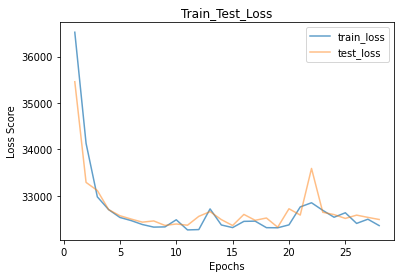

29
Train Epoch: 29 [0/7471 (0%)]	Loss: 34072.371094
Train Epoch: 29 [160/7471 (2%)]	Loss: 30465.230469
Train Epoch: 29 [320/7471 (4%)]	Loss: 31384.316406
Train Epoch: 29 [480/7471 (6%)]	Loss: 32135.654297
Train Epoch: 29 [640/7471 (9%)]	Loss: 32770.609375
Train Epoch: 29 [800/7471 (11%)]	Loss: 32560.097656
Train Epoch: 29 [960/7471 (13%)]	Loss: 32597.226562
Train Epoch: 29 [1120/7471 (15%)]	Loss: 31748.248047
Train Epoch: 29 [1280/7471 (17%)]	Loss: 32354.712891
Train Epoch: 29 [1440/7471 (19%)]	Loss: 32063.060547
Train Epoch: 29 [1600/7471 (21%)]	Loss: 32907.250000
Train Epoch: 29 [1760/7471 (24%)]	Loss: 31765.298828
Train Epoch: 29 [1920/7471 (26%)]	Loss: 29725.548828
Train Epoch: 29 [2080/7471 (28%)]	Loss: 32787.304688
Train Epoch: 29 [2240/7471 (30%)]	Loss: 31244.423828
Train Epoch: 29 [2400/7471 (32%)]	Loss: 32929.523438
Train Epoch: 29 [2560/7471 (34%)]	Loss: 30979.957031
Train Epoch: 29 [2720/7471 (36%)]	Loss: 32822.785156
Train Epoch: 29 [2880/7471 (39%)]	Loss: 30911.572266
Trai

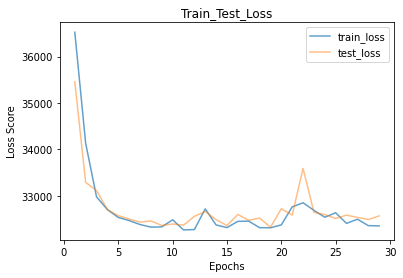

30
Train Epoch: 30 [0/7471 (0%)]	Loss: 32414.972656
Train Epoch: 30 [160/7471 (2%)]	Loss: 31362.621094
Train Epoch: 30 [320/7471 (4%)]	Loss: 31883.824219
Train Epoch: 30 [480/7471 (6%)]	Loss: 31596.296875
Train Epoch: 30 [640/7471 (9%)]	Loss: 33813.449219
Train Epoch: 30 [800/7471 (11%)]	Loss: 32653.070312
Train Epoch: 30 [960/7471 (13%)]	Loss: 30077.599609
Train Epoch: 30 [1120/7471 (15%)]	Loss: 32318.671875
Train Epoch: 30 [1280/7471 (17%)]	Loss: 32507.083984
Train Epoch: 30 [1440/7471 (19%)]	Loss: 31871.701172
Train Epoch: 30 [1600/7471 (21%)]	Loss: 32745.970703
Train Epoch: 30 [1760/7471 (24%)]	Loss: 31685.750000
Train Epoch: 30 [1920/7471 (26%)]	Loss: 32444.863281
Train Epoch: 30 [2080/7471 (28%)]	Loss: 33150.402344
Train Epoch: 30 [2240/7471 (30%)]	Loss: 32034.076172
Train Epoch: 30 [2400/7471 (32%)]	Loss: 32773.160156
Train Epoch: 30 [2560/7471 (34%)]	Loss: 32418.183594
Train Epoch: 30 [2720/7471 (36%)]	Loss: 33461.640625
Train Epoch: 30 [2880/7471 (39%)]	Loss: 30108.683594
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


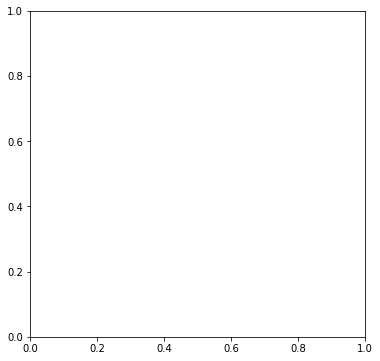

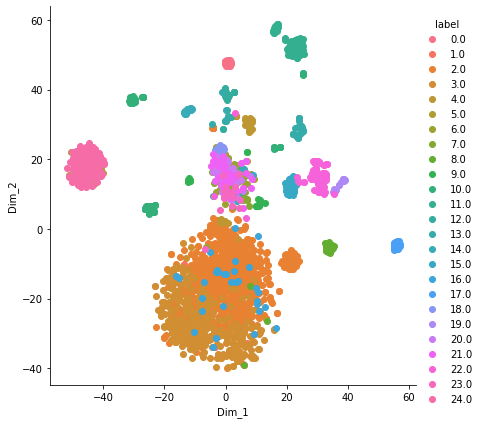

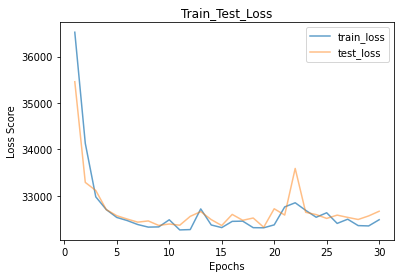

31
Train Epoch: 31 [0/7471 (0%)]	Loss: 33325.898438
Train Epoch: 31 [160/7471 (2%)]	Loss: 33545.089844
Train Epoch: 31 [320/7471 (4%)]	Loss: 31980.777344
Train Epoch: 31 [480/7471 (6%)]	Loss: 31572.835938
Train Epoch: 31 [640/7471 (9%)]	Loss: 31508.314453
Train Epoch: 31 [800/7471 (11%)]	Loss: 32535.957031
Train Epoch: 31 [960/7471 (13%)]	Loss: 32591.990234
Train Epoch: 31 [1120/7471 (15%)]	Loss: 33073.906250
Train Epoch: 31 [1280/7471 (17%)]	Loss: 33936.113281
Train Epoch: 31 [1440/7471 (19%)]	Loss: 33615.445312
Train Epoch: 31 [1600/7471 (21%)]	Loss: 31710.777344
Train Epoch: 31 [1760/7471 (24%)]	Loss: 31155.431641
Train Epoch: 31 [1920/7471 (26%)]	Loss: 30829.939453
Train Epoch: 31 [2080/7471 (28%)]	Loss: 32458.492188
Train Epoch: 31 [2240/7471 (30%)]	Loss: 32735.798828
Train Epoch: 31 [2400/7471 (32%)]	Loss: 31230.966797
Train Epoch: 31 [2560/7471 (34%)]	Loss: 33315.093750
Train Epoch: 31 [2720/7471 (36%)]	Loss: 32607.128906
Train Epoch: 31 [2880/7471 (39%)]	Loss: 32040.140625
Trai

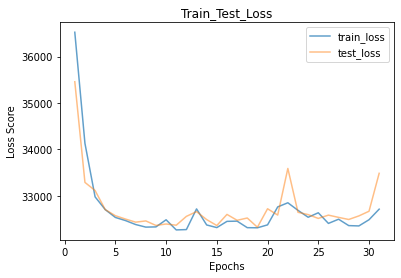

32
Train Epoch: 32 [0/7471 (0%)]	Loss: 33444.933594
Train Epoch: 32 [160/7471 (2%)]	Loss: 33874.371094
Train Epoch: 32 [320/7471 (4%)]	Loss: 33787.914062
Train Epoch: 32 [480/7471 (6%)]	Loss: 34100.082031
Train Epoch: 32 [640/7471 (9%)]	Loss: 32539.101562
Train Epoch: 32 [800/7471 (11%)]	Loss: 32596.009766
Train Epoch: 32 [960/7471 (13%)]	Loss: 32755.464844
Train Epoch: 32 [1120/7471 (15%)]	Loss: 32008.814453
Train Epoch: 32 [1280/7471 (17%)]	Loss: 33139.785156
Train Epoch: 32 [1440/7471 (19%)]	Loss: 33453.558594
Train Epoch: 32 [1600/7471 (21%)]	Loss: 32630.107422
Train Epoch: 32 [1760/7471 (24%)]	Loss: 32958.925781
Train Epoch: 32 [1920/7471 (26%)]	Loss: 33439.902344
Train Epoch: 32 [2080/7471 (28%)]	Loss: 31826.267578
Train Epoch: 32 [2240/7471 (30%)]	Loss: 33203.246094
Train Epoch: 32 [2400/7471 (32%)]	Loss: 33623.250000
Train Epoch: 32 [2560/7471 (34%)]	Loss: 32376.132812
Train Epoch: 32 [2720/7471 (36%)]	Loss: 33531.050781
Train Epoch: 32 [2880/7471 (39%)]	Loss: 33981.882812
Trai

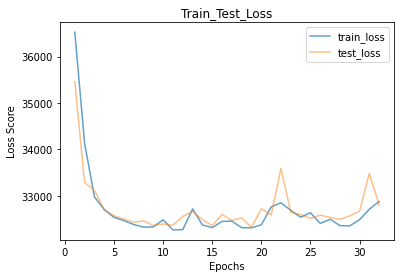

33
Train Epoch: 33 [0/7471 (0%)]	Loss: 33005.953125
Train Epoch: 33 [160/7471 (2%)]	Loss: 32853.175781
Train Epoch: 33 [320/7471 (4%)]	Loss: 32219.238281
Train Epoch: 33 [480/7471 (6%)]	Loss: 31503.541016
Train Epoch: 33 [640/7471 (9%)]	Loss: 33608.695312
Train Epoch: 33 [800/7471 (11%)]	Loss: 33336.382812
Train Epoch: 33 [960/7471 (13%)]	Loss: 34022.285156
Train Epoch: 33 [1120/7471 (15%)]	Loss: 32671.533203
Train Epoch: 33 [1280/7471 (17%)]	Loss: 32750.611328
Train Epoch: 33 [1440/7471 (19%)]	Loss: 31532.990234
Train Epoch: 33 [1600/7471 (21%)]	Loss: 32479.556641
Train Epoch: 33 [1760/7471 (24%)]	Loss: 33505.105469
Train Epoch: 33 [1920/7471 (26%)]	Loss: 31809.605469
Train Epoch: 33 [2080/7471 (28%)]	Loss: 31374.978516
Train Epoch: 33 [2240/7471 (30%)]	Loss: 32257.136719
Train Epoch: 33 [2400/7471 (32%)]	Loss: 30884.423828
Train Epoch: 33 [2560/7471 (34%)]	Loss: 33539.023438
Train Epoch: 33 [2720/7471 (36%)]	Loss: 33657.847656
Train Epoch: 33 [2880/7471 (39%)]	Loss: 33422.941406
Trai

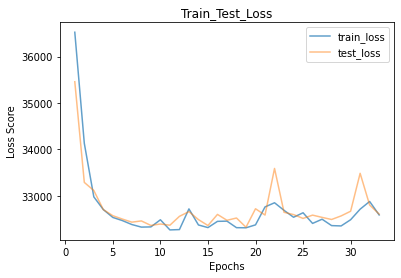

34
Train Epoch: 34 [0/7471 (0%)]	Loss: 32383.199219
Train Epoch: 34 [160/7471 (2%)]	Loss: 30631.445312
Train Epoch: 34 [320/7471 (4%)]	Loss: 33442.773438
Train Epoch: 34 [480/7471 (6%)]	Loss: 30917.828125
Train Epoch: 34 [640/7471 (9%)]	Loss: 32276.156250
Train Epoch: 34 [800/7471 (11%)]	Loss: 31670.984375
Train Epoch: 34 [960/7471 (13%)]	Loss: 31720.863281
Train Epoch: 34 [1120/7471 (15%)]	Loss: 33985.570312
Train Epoch: 34 [1280/7471 (17%)]	Loss: 33255.679688
Train Epoch: 34 [1440/7471 (19%)]	Loss: 33526.800781
Train Epoch: 34 [1600/7471 (21%)]	Loss: 32350.113281
Train Epoch: 34 [1760/7471 (24%)]	Loss: 32130.398438
Train Epoch: 34 [1920/7471 (26%)]	Loss: 32747.394531
Train Epoch: 34 [2080/7471 (28%)]	Loss: 33411.589844
Train Epoch: 34 [2240/7471 (30%)]	Loss: 33403.648438
Train Epoch: 34 [2400/7471 (32%)]	Loss: 32039.572266
Train Epoch: 34 [2560/7471 (34%)]	Loss: 33842.042969
Train Epoch: 34 [2720/7471 (36%)]	Loss: 31244.765625
Train Epoch: 34 [2880/7471 (39%)]	Loss: 32764.033203
Trai

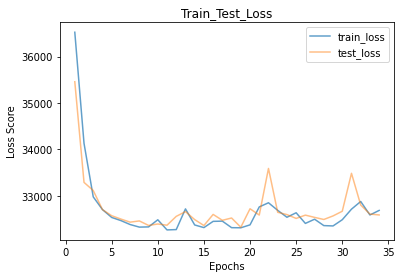

35
Train Epoch: 35 [0/7471 (0%)]	Loss: 32357.556641
Train Epoch: 35 [160/7471 (2%)]	Loss: 33689.773438
Train Epoch: 35 [320/7471 (4%)]	Loss: 32768.117188
Train Epoch: 35 [480/7471 (6%)]	Loss: 31859.408203
Train Epoch: 35 [640/7471 (9%)]	Loss: 33779.804688
Train Epoch: 35 [800/7471 (11%)]	Loss: 33496.015625
Train Epoch: 35 [960/7471 (13%)]	Loss: 31501.884766
Train Epoch: 35 [1120/7471 (15%)]	Loss: 31514.457031
Train Epoch: 35 [1280/7471 (17%)]	Loss: 31847.933594
Train Epoch: 35 [1440/7471 (19%)]	Loss: 31144.308594
Train Epoch: 35 [1600/7471 (21%)]	Loss: 33168.515625
Train Epoch: 35 [1760/7471 (24%)]	Loss: 32552.373047
Train Epoch: 35 [1920/7471 (26%)]	Loss: 31907.529297
Train Epoch: 35 [2080/7471 (28%)]	Loss: 32355.683594
Train Epoch: 35 [2240/7471 (30%)]	Loss: 33044.222656
Train Epoch: 35 [2400/7471 (32%)]	Loss: 32250.062500
Train Epoch: 35 [2560/7471 (34%)]	Loss: 33249.453125
Train Epoch: 35 [2720/7471 (36%)]	Loss: 31899.720703
Train Epoch: 35 [2880/7471 (39%)]	Loss: 33157.343750
Trai

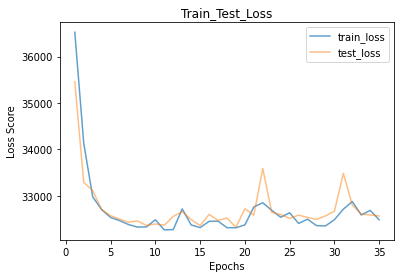

36
Train Epoch: 36 [0/7471 (0%)]	Loss: 33057.269531
Train Epoch: 36 [160/7471 (2%)]	Loss: 31384.425781
Train Epoch: 36 [320/7471 (4%)]	Loss: 33010.152344
Train Epoch: 36 [480/7471 (6%)]	Loss: 32829.835938
Train Epoch: 36 [640/7471 (9%)]	Loss: 31723.554688
Train Epoch: 36 [800/7471 (11%)]	Loss: 33111.292969
Train Epoch: 36 [960/7471 (13%)]	Loss: 33422.054688
Train Epoch: 36 [1120/7471 (15%)]	Loss: 33765.011719
Train Epoch: 36 [1280/7471 (17%)]	Loss: 32879.882812
Train Epoch: 36 [1440/7471 (19%)]	Loss: 33304.175781
Train Epoch: 36 [1600/7471 (21%)]	Loss: 33385.750000
Train Epoch: 36 [1760/7471 (24%)]	Loss: 32846.625000
Train Epoch: 36 [1920/7471 (26%)]	Loss: 31644.851562
Train Epoch: 36 [2080/7471 (28%)]	Loss: 32748.501953
Train Epoch: 36 [2240/7471 (30%)]	Loss: 32188.566406
Train Epoch: 36 [2400/7471 (32%)]	Loss: 30484.912109
Train Epoch: 36 [2560/7471 (34%)]	Loss: 32723.875000
Train Epoch: 36 [2720/7471 (36%)]	Loss: 31646.150391
Train Epoch: 36 [2880/7471 (39%)]	Loss: 32254.599609
Trai

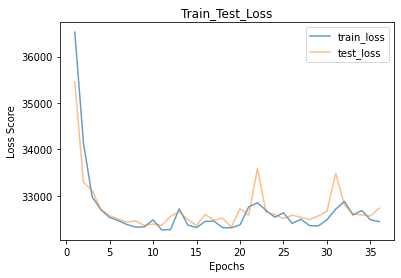

37
Train Epoch: 37 [0/7471 (0%)]	Loss: 32081.037109
Train Epoch: 37 [160/7471 (2%)]	Loss: 32700.162109
Train Epoch: 37 [320/7471 (4%)]	Loss: 33349.226562
Train Epoch: 37 [480/7471 (6%)]	Loss: 32020.785156
Train Epoch: 37 [640/7471 (9%)]	Loss: 31524.957031
Train Epoch: 37 [800/7471 (11%)]	Loss: 33175.851562
Train Epoch: 37 [960/7471 (13%)]	Loss: 32965.632812
Train Epoch: 37 [1120/7471 (15%)]	Loss: 33528.574219
Train Epoch: 37 [1280/7471 (17%)]	Loss: 32440.027344
Train Epoch: 37 [1440/7471 (19%)]	Loss: 32964.503906
Train Epoch: 37 [1600/7471 (21%)]	Loss: 32560.654297
Train Epoch: 37 [1760/7471 (24%)]	Loss: 31267.501953
Train Epoch: 37 [1920/7471 (26%)]	Loss: 33550.476562
Train Epoch: 37 [2080/7471 (28%)]	Loss: 33123.394531
Train Epoch: 37 [2240/7471 (30%)]	Loss: 32888.253906
Train Epoch: 37 [2400/7471 (32%)]	Loss: 33524.488281
Train Epoch: 37 [2560/7471 (34%)]	Loss: 32596.763672
Train Epoch: 37 [2720/7471 (36%)]	Loss: 32765.218750
Train Epoch: 37 [2880/7471 (39%)]	Loss: 32813.894531
Trai

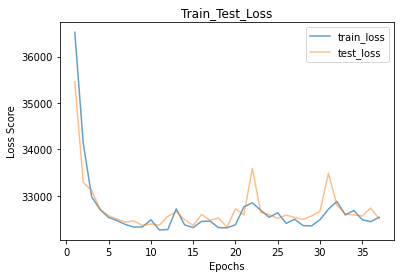

38
Train Epoch: 38 [0/7471 (0%)]	Loss: 33356.636719
Train Epoch: 38 [160/7471 (2%)]	Loss: 33394.464844
Train Epoch: 38 [320/7471 (4%)]	Loss: 32750.378906
Train Epoch: 38 [480/7471 (6%)]	Loss: 32366.515625
Train Epoch: 38 [640/7471 (9%)]	Loss: 32667.833984
Train Epoch: 38 [800/7471 (11%)]	Loss: 33274.902344
Train Epoch: 38 [960/7471 (13%)]	Loss: 31841.636719
Train Epoch: 38 [1120/7471 (15%)]	Loss: 31980.025391
Train Epoch: 38 [1280/7471 (17%)]	Loss: 32576.787109
Train Epoch: 38 [1440/7471 (19%)]	Loss: 31626.023438
Train Epoch: 38 [1600/7471 (21%)]	Loss: 32381.634766
Train Epoch: 38 [1760/7471 (24%)]	Loss: 32382.019531
Train Epoch: 38 [1920/7471 (26%)]	Loss: 32233.046875
Train Epoch: 38 [2080/7471 (28%)]	Loss: 30410.824219
Train Epoch: 38 [2240/7471 (30%)]	Loss: 32118.402344
Train Epoch: 38 [2400/7471 (32%)]	Loss: 33909.265625
Train Epoch: 38 [2560/7471 (34%)]	Loss: 32778.964844
Train Epoch: 38 [2720/7471 (36%)]	Loss: 32324.398438
Train Epoch: 38 [2880/7471 (39%)]	Loss: 32502.160156
Trai

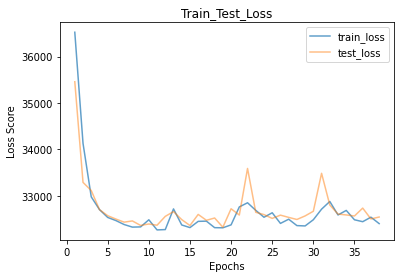

39
Train Epoch: 39 [0/7471 (0%)]	Loss: 33333.570312
Train Epoch: 39 [160/7471 (2%)]	Loss: 30945.341797
Train Epoch: 39 [320/7471 (4%)]	Loss: 33262.378906
Train Epoch: 39 [480/7471 (6%)]	Loss: 32769.339844
Train Epoch: 39 [640/7471 (9%)]	Loss: 33555.019531
Train Epoch: 39 [800/7471 (11%)]	Loss: 32075.710938
Train Epoch: 39 [960/7471 (13%)]	Loss: 32562.966797
Train Epoch: 39 [1120/7471 (15%)]	Loss: 31720.593750
Train Epoch: 39 [1280/7471 (17%)]	Loss: 32142.966797
Train Epoch: 39 [1440/7471 (19%)]	Loss: 33173.066406
Train Epoch: 39 [1600/7471 (21%)]	Loss: 33351.265625
Train Epoch: 39 [1760/7471 (24%)]	Loss: 31695.548828
Train Epoch: 39 [1920/7471 (26%)]	Loss: 33410.398438
Train Epoch: 39 [2080/7471 (28%)]	Loss: 33063.832031
Train Epoch: 39 [2240/7471 (30%)]	Loss: 33627.667969
Train Epoch: 39 [2400/7471 (32%)]	Loss: 32371.296875
Train Epoch: 39 [2560/7471 (34%)]	Loss: 33234.328125
Train Epoch: 39 [2720/7471 (36%)]	Loss: 32804.796875
Train Epoch: 39 [2880/7471 (39%)]	Loss: 33239.855469
Trai

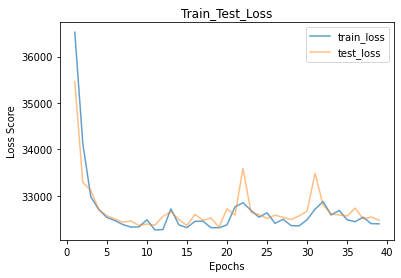

40
Train Epoch: 40 [0/7471 (0%)]	Loss: 31462.294922
Train Epoch: 40 [160/7471 (2%)]	Loss: 33073.007812
Train Epoch: 40 [320/7471 (4%)]	Loss: 32543.771484
Train Epoch: 40 [480/7471 (6%)]	Loss: 33505.773438
Train Epoch: 40 [640/7471 (9%)]	Loss: 33502.972656
Train Epoch: 40 [800/7471 (11%)]	Loss: 30598.005859
Train Epoch: 40 [960/7471 (13%)]	Loss: 32044.314453
Train Epoch: 40 [1120/7471 (15%)]	Loss: 32962.195312
Train Epoch: 40 [1280/7471 (17%)]	Loss: 31463.419922
Train Epoch: 40 [1440/7471 (19%)]	Loss: 32023.183594
Train Epoch: 40 [1600/7471 (21%)]	Loss: 30291.310547
Train Epoch: 40 [1760/7471 (24%)]	Loss: 32804.296875
Train Epoch: 40 [1920/7471 (26%)]	Loss: 32117.527344
Train Epoch: 40 [2080/7471 (28%)]	Loss: 32274.044922
Train Epoch: 40 [2240/7471 (30%)]	Loss: 31590.822266
Train Epoch: 40 [2400/7471 (32%)]	Loss: 32854.792969
Train Epoch: 40 [2560/7471 (34%)]	Loss: 33066.582031
Train Epoch: 40 [2720/7471 (36%)]	Loss: 32027.771484
Train Epoch: 40 [2880/7471 (39%)]	Loss: 33242.160156
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


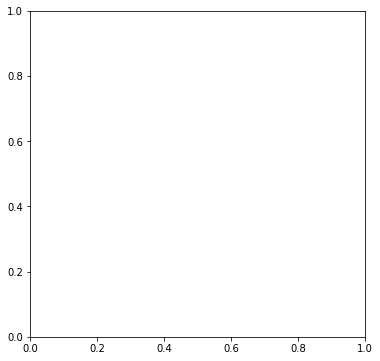

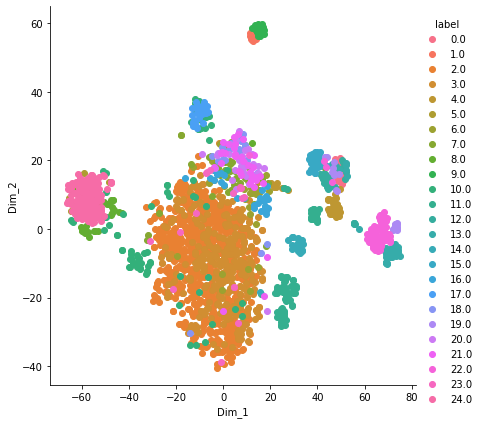

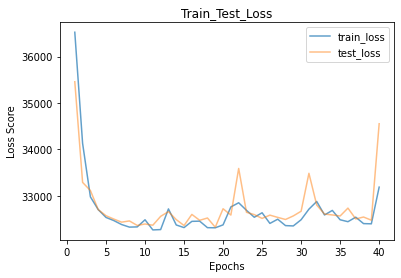

41
Train Epoch: 41 [0/7471 (0%)]	Loss: 34483.578125
Train Epoch: 41 [160/7471 (2%)]	Loss: 34395.875000
Train Epoch: 41 [320/7471 (4%)]	Loss: 34843.328125
Train Epoch: 41 [480/7471 (6%)]	Loss: 33698.753906
Train Epoch: 41 [640/7471 (9%)]	Loss: 34238.503906
Train Epoch: 41 [800/7471 (11%)]	Loss: 34360.144531
Train Epoch: 41 [960/7471 (13%)]	Loss: 33455.335938
Train Epoch: 41 [1120/7471 (15%)]	Loss: 34046.699219
Train Epoch: 41 [1280/7471 (17%)]	Loss: 33060.597656
Train Epoch: 41 [1440/7471 (19%)]	Loss: 33078.609375
Train Epoch: 41 [1600/7471 (21%)]	Loss: 34086.785156
Train Epoch: 41 [1760/7471 (24%)]	Loss: 33453.492188
Train Epoch: 41 [1920/7471 (26%)]	Loss: 33786.367188
Train Epoch: 41 [2080/7471 (28%)]	Loss: 33603.335938
Train Epoch: 41 [2240/7471 (30%)]	Loss: 33351.539062
Train Epoch: 41 [2400/7471 (32%)]	Loss: 33690.066406
Train Epoch: 41 [2560/7471 (34%)]	Loss: 33749.328125
Train Epoch: 41 [2720/7471 (36%)]	Loss: 32955.675781
Train Epoch: 41 [2880/7471 (39%)]	Loss: 33135.042969
Trai

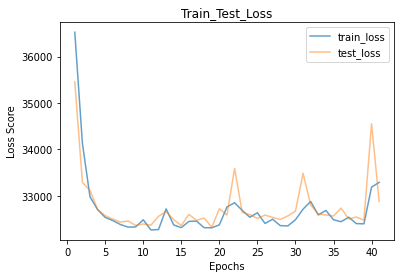

42
Train Epoch: 42 [0/7471 (0%)]	Loss: 32065.500000
Train Epoch: 42 [160/7471 (2%)]	Loss: 32815.003906
Train Epoch: 42 [320/7471 (4%)]	Loss: 33729.566406
Train Epoch: 42 [480/7471 (6%)]	Loss: 31843.525391
Train Epoch: 42 [640/7471 (9%)]	Loss: 33624.769531
Train Epoch: 42 [800/7471 (11%)]	Loss: 33313.980469
Train Epoch: 42 [960/7471 (13%)]	Loss: 33483.625000
Train Epoch: 42 [1120/7471 (15%)]	Loss: 32395.525391
Train Epoch: 42 [1280/7471 (17%)]	Loss: 33591.632812
Train Epoch: 42 [1440/7471 (19%)]	Loss: 33262.808594
Train Epoch: 42 [1600/7471 (21%)]	Loss: 31877.623047
Train Epoch: 42 [1760/7471 (24%)]	Loss: 33012.906250
Train Epoch: 42 [1920/7471 (26%)]	Loss: 33607.726562
Train Epoch: 42 [2080/7471 (28%)]	Loss: 32091.982422
Train Epoch: 42 [2240/7471 (30%)]	Loss: 31416.027344
Train Epoch: 42 [2400/7471 (32%)]	Loss: 31890.921875
Train Epoch: 42 [2560/7471 (34%)]	Loss: 31476.226562
Train Epoch: 42 [2720/7471 (36%)]	Loss: 32286.800781
Train Epoch: 42 [2880/7471 (39%)]	Loss: 31773.792969
Trai

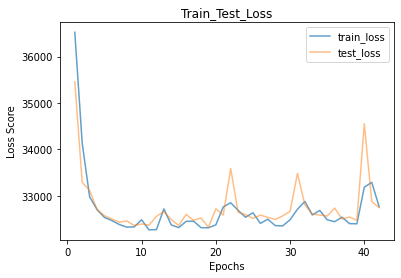

43
Train Epoch: 43 [0/7471 (0%)]	Loss: 31859.449219
Train Epoch: 43 [160/7471 (2%)]	Loss: 33192.738281
Train Epoch: 43 [320/7471 (4%)]	Loss: 33405.753906
Train Epoch: 43 [480/7471 (6%)]	Loss: 33233.585938
Train Epoch: 43 [640/7471 (9%)]	Loss: 33526.347656
Train Epoch: 43 [800/7471 (11%)]	Loss: 33221.902344
Train Epoch: 43 [960/7471 (13%)]	Loss: 32802.843750
Train Epoch: 43 [1120/7471 (15%)]	Loss: 32581.707031
Train Epoch: 43 [1280/7471 (17%)]	Loss: 32967.082031
Train Epoch: 43 [1440/7471 (19%)]	Loss: 31790.019531
Train Epoch: 43 [1600/7471 (21%)]	Loss: 33256.828125
Train Epoch: 43 [1760/7471 (24%)]	Loss: 32156.060547
Train Epoch: 43 [1920/7471 (26%)]	Loss: 32199.167969
Train Epoch: 43 [2080/7471 (28%)]	Loss: 32013.748047
Train Epoch: 43 [2240/7471 (30%)]	Loss: 32815.789062
Train Epoch: 43 [2400/7471 (32%)]	Loss: 31941.937500
Train Epoch: 43 [2560/7471 (34%)]	Loss: 32342.037109
Train Epoch: 43 [2720/7471 (36%)]	Loss: 30993.884766
Train Epoch: 43 [2880/7471 (39%)]	Loss: 32313.048828
Trai

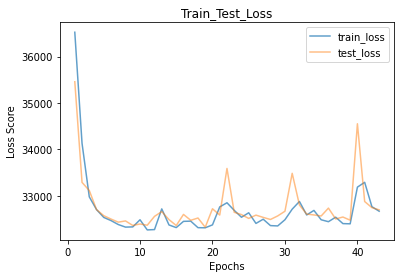

44
Train Epoch: 44 [0/7471 (0%)]	Loss: 31911.603516
Train Epoch: 44 [160/7471 (2%)]	Loss: 31803.546875
Train Epoch: 44 [320/7471 (4%)]	Loss: 33082.406250
Train Epoch: 44 [480/7471 (6%)]	Loss: 31366.173828
Train Epoch: 44 [640/7471 (9%)]	Loss: 32069.375000
Train Epoch: 44 [800/7471 (11%)]	Loss: 32256.892578
Train Epoch: 44 [960/7471 (13%)]	Loss: 33849.464844
Train Epoch: 44 [1120/7471 (15%)]	Loss: 30835.414062
Train Epoch: 44 [1280/7471 (17%)]	Loss: 32865.679688
Train Epoch: 44 [1440/7471 (19%)]	Loss: 32289.261719
Train Epoch: 44 [1600/7471 (21%)]	Loss: 31497.576172
Train Epoch: 44 [1760/7471 (24%)]	Loss: 32823.238281
Train Epoch: 44 [1920/7471 (26%)]	Loss: 33878.570312
Train Epoch: 44 [2080/7471 (28%)]	Loss: 33249.730469
Train Epoch: 44 [2240/7471 (30%)]	Loss: 32714.130859
Train Epoch: 44 [2400/7471 (32%)]	Loss: 34030.019531
Train Epoch: 44 [2560/7471 (34%)]	Loss: 33670.363281
Train Epoch: 44 [2720/7471 (36%)]	Loss: 33541.105469
Train Epoch: 44 [2880/7471 (39%)]	Loss: 33735.625000
Trai

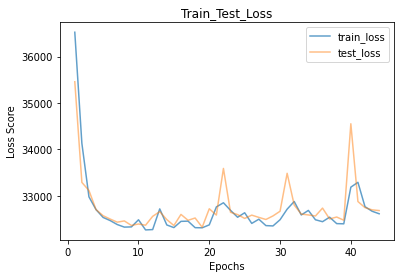

45
Train Epoch: 45 [0/7471 (0%)]	Loss: 33173.835938
Train Epoch: 45 [160/7471 (2%)]	Loss: 32049.478516
Train Epoch: 45 [320/7471 (4%)]	Loss: 33110.347656
Train Epoch: 45 [480/7471 (6%)]	Loss: 33432.628906
Train Epoch: 45 [640/7471 (9%)]	Loss: 32203.187500
Train Epoch: 45 [800/7471 (11%)]	Loss: 31687.632812
Train Epoch: 45 [960/7471 (13%)]	Loss: 32586.714844
Train Epoch: 45 [1120/7471 (15%)]	Loss: 31564.658203
Train Epoch: 45 [1280/7471 (17%)]	Loss: 33150.390625
Train Epoch: 45 [1440/7471 (19%)]	Loss: 32862.851562
Train Epoch: 45 [1600/7471 (21%)]	Loss: 32213.529297
Train Epoch: 45 [1760/7471 (24%)]	Loss: 33624.742188
Train Epoch: 45 [1920/7471 (26%)]	Loss: 33400.339844
Train Epoch: 45 [2080/7471 (28%)]	Loss: 32157.615234
Train Epoch: 45 [2240/7471 (30%)]	Loss: 31471.339844
Train Epoch: 45 [2400/7471 (32%)]	Loss: 32007.888672
Train Epoch: 45 [2560/7471 (34%)]	Loss: 32613.628906
Train Epoch: 45 [2720/7471 (36%)]	Loss: 30546.740234
Train Epoch: 45 [2880/7471 (39%)]	Loss: 33762.824219
Trai

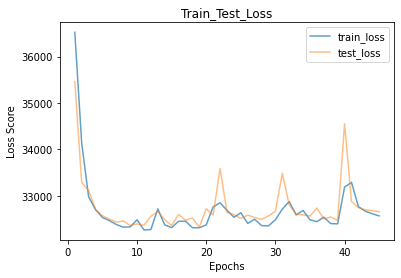

46
Train Epoch: 46 [0/7471 (0%)]	Loss: 32458.128906
Train Epoch: 46 [160/7471 (2%)]	Loss: 32723.453125
Train Epoch: 46 [320/7471 (4%)]	Loss: 33189.246094
Train Epoch: 46 [480/7471 (6%)]	Loss: 31761.400391
Train Epoch: 46 [640/7471 (9%)]	Loss: 32862.992188
Train Epoch: 46 [800/7471 (11%)]	Loss: 32501.140625
Train Epoch: 46 [960/7471 (13%)]	Loss: 32448.365234
Train Epoch: 46 [1120/7471 (15%)]	Loss: 33824.011719
Train Epoch: 46 [1280/7471 (17%)]	Loss: 33344.343750
Train Epoch: 46 [1440/7471 (19%)]	Loss: 33076.781250
Train Epoch: 46 [1600/7471 (21%)]	Loss: 33208.675781
Train Epoch: 46 [1760/7471 (24%)]	Loss: 32985.214844
Train Epoch: 46 [1920/7471 (26%)]	Loss: 33902.480469
Train Epoch: 46 [2080/7471 (28%)]	Loss: 32736.585938
Train Epoch: 46 [2240/7471 (30%)]	Loss: 32461.832031
Train Epoch: 46 [2400/7471 (32%)]	Loss: 33013.371094
Train Epoch: 46 [2560/7471 (34%)]	Loss: 33155.058594
Train Epoch: 46 [2720/7471 (36%)]	Loss: 33405.675781
Train Epoch: 46 [2880/7471 (39%)]	Loss: 32825.464844
Trai

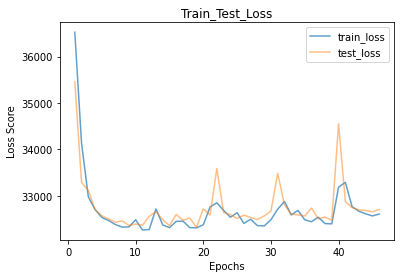

47
Train Epoch: 47 [0/7471 (0%)]	Loss: 33308.121094
Train Epoch: 47 [160/7471 (2%)]	Loss: 32720.037109
Train Epoch: 47 [320/7471 (4%)]	Loss: 33472.960938
Train Epoch: 47 [480/7471 (6%)]	Loss: 31248.138672
Train Epoch: 47 [640/7471 (9%)]	Loss: 32291.560547
Train Epoch: 47 [800/7471 (11%)]	Loss: 32871.867188
Train Epoch: 47 [960/7471 (13%)]	Loss: 33212.925781
Train Epoch: 47 [1120/7471 (15%)]	Loss: 33887.062500
Train Epoch: 47 [1280/7471 (17%)]	Loss: 32108.423828
Train Epoch: 47 [1440/7471 (19%)]	Loss: 32744.791016
Train Epoch: 47 [1600/7471 (21%)]	Loss: 33849.988281
Train Epoch: 47 [1760/7471 (24%)]	Loss: 30177.683594
Train Epoch: 47 [1920/7471 (26%)]	Loss: 32572.714844
Train Epoch: 47 [2080/7471 (28%)]	Loss: 31418.197266
Train Epoch: 47 [2240/7471 (30%)]	Loss: 32783.785156
Train Epoch: 47 [2400/7471 (32%)]	Loss: 31652.187500
Train Epoch: 47 [2560/7471 (34%)]	Loss: 30662.119141
Train Epoch: 47 [2720/7471 (36%)]	Loss: 30842.296875
Train Epoch: 47 [2880/7471 (39%)]	Loss: 32842.566406
Trai

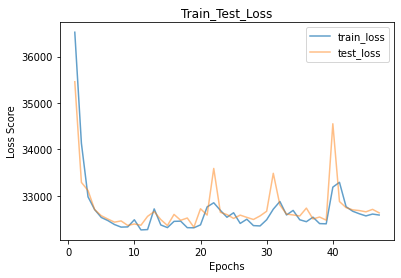

48
Train Epoch: 48 [0/7471 (0%)]	Loss: 33346.988281
Train Epoch: 48 [160/7471 (2%)]	Loss: 33911.324219
Train Epoch: 48 [320/7471 (4%)]	Loss: 32634.355469
Train Epoch: 48 [480/7471 (6%)]	Loss: 33686.679688
Train Epoch: 48 [640/7471 (9%)]	Loss: 33526.554688
Train Epoch: 48 [800/7471 (11%)]	Loss: 32544.251953
Train Epoch: 48 [960/7471 (13%)]	Loss: 32484.033203
Train Epoch: 48 [1120/7471 (15%)]	Loss: 34019.179688
Train Epoch: 48 [1280/7471 (17%)]	Loss: 33345.296875
Train Epoch: 48 [1440/7471 (19%)]	Loss: 31850.785156
Train Epoch: 48 [1600/7471 (21%)]	Loss: 29272.679688
Train Epoch: 48 [1760/7471 (24%)]	Loss: 31674.984375
Train Epoch: 48 [1920/7471 (26%)]	Loss: 32606.224609
Train Epoch: 48 [2080/7471 (28%)]	Loss: 31272.369141
Train Epoch: 48 [2240/7471 (30%)]	Loss: 30944.662109
Train Epoch: 48 [2400/7471 (32%)]	Loss: 28759.382812
Train Epoch: 48 [2560/7471 (34%)]	Loss: 31876.443359
Train Epoch: 48 [2720/7471 (36%)]	Loss: 31720.199219
Train Epoch: 48 [2880/7471 (39%)]	Loss: 32655.335938
Trai

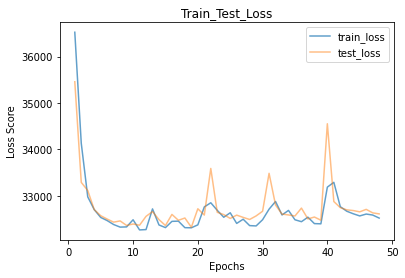

49
Train Epoch: 49 [0/7471 (0%)]	Loss: 32861.660156
Train Epoch: 49 [160/7471 (2%)]	Loss: 32591.912109
Train Epoch: 49 [320/7471 (4%)]	Loss: 32788.226562
Train Epoch: 49 [480/7471 (6%)]	Loss: 31465.425781
Train Epoch: 49 [640/7471 (9%)]	Loss: 33446.117188
Train Epoch: 49 [800/7471 (11%)]	Loss: 33202.238281
Train Epoch: 49 [960/7471 (13%)]	Loss: 33393.917969
Train Epoch: 49 [1120/7471 (15%)]	Loss: 32327.544922
Train Epoch: 49 [1280/7471 (17%)]	Loss: 32703.173828
Train Epoch: 49 [1440/7471 (19%)]	Loss: 32707.236328
Train Epoch: 49 [1600/7471 (21%)]	Loss: 31903.880859
Train Epoch: 49 [1760/7471 (24%)]	Loss: 32556.335938
Train Epoch: 49 [1920/7471 (26%)]	Loss: 32102.142578
Train Epoch: 49 [2080/7471 (28%)]	Loss: 30689.927734
Train Epoch: 49 [2240/7471 (30%)]	Loss: 32752.417969
Train Epoch: 49 [2400/7471 (32%)]	Loss: 33299.453125
Train Epoch: 49 [2560/7471 (34%)]	Loss: 33484.523438
Train Epoch: 49 [2720/7471 (36%)]	Loss: 32588.742188
Train Epoch: 49 [2880/7471 (39%)]	Loss: 31417.533203
Trai

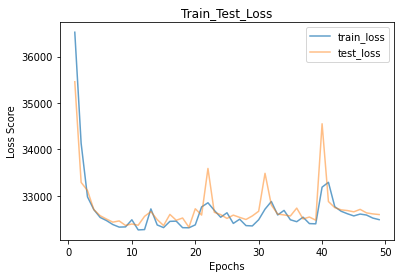

50
Train Epoch: 50 [0/7471 (0%)]	Loss: 31639.927734
Train Epoch: 50 [160/7471 (2%)]	Loss: 33277.300781
Train Epoch: 50 [320/7471 (4%)]	Loss: 32425.578125
Train Epoch: 50 [480/7471 (6%)]	Loss: 33356.460938
Train Epoch: 50 [640/7471 (9%)]	Loss: 32657.972656
Train Epoch: 50 [800/7471 (11%)]	Loss: 33426.980469
Train Epoch: 50 [960/7471 (13%)]	Loss: 32986.359375
Train Epoch: 50 [1120/7471 (15%)]	Loss: 31449.201172
Train Epoch: 50 [1280/7471 (17%)]	Loss: 30019.496094
Train Epoch: 50 [1440/7471 (19%)]	Loss: 33076.171875
Train Epoch: 50 [1600/7471 (21%)]	Loss: 33650.039062
Train Epoch: 50 [1760/7471 (24%)]	Loss: 31659.267578
Train Epoch: 50 [1920/7471 (26%)]	Loss: 33274.945312
Train Epoch: 50 [2080/7471 (28%)]	Loss: 32421.023438
Train Epoch: 50 [2240/7471 (30%)]	Loss: 32374.550781
Train Epoch: 50 [2400/7471 (32%)]	Loss: 33095.503906
Train Epoch: 50 [2560/7471 (34%)]	Loss: 32757.791016
Train Epoch: 50 [2720/7471 (36%)]	Loss: 32782.152344
Train Epoch: 50 [2880/7471 (39%)]	Loss: 33312.359375
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


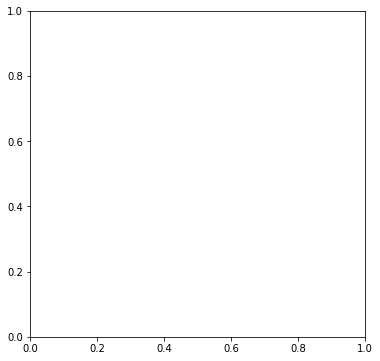

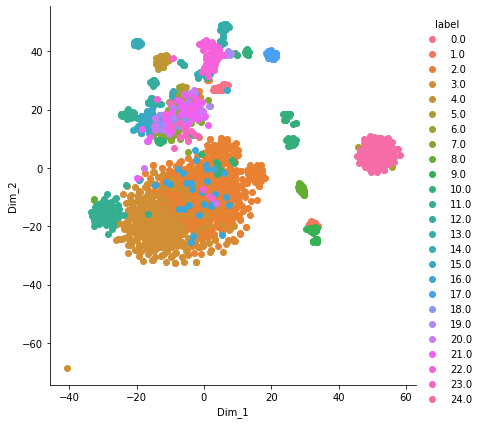

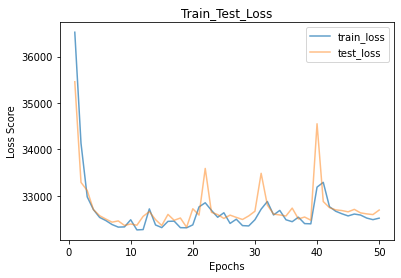

51
Train Epoch: 51 [0/7471 (0%)]	Loss: 32183.050781
Train Epoch: 51 [160/7471 (2%)]	Loss: 32656.535156
Train Epoch: 51 [320/7471 (4%)]	Loss: 32468.451172
Train Epoch: 51 [480/7471 (6%)]	Loss: 31634.423828
Train Epoch: 51 [640/7471 (9%)]	Loss: 32013.257812
Train Epoch: 51 [800/7471 (11%)]	Loss: 33470.804688
Train Epoch: 51 [960/7471 (13%)]	Loss: 32305.550781
Train Epoch: 51 [1120/7471 (15%)]	Loss: 32165.156250
Train Epoch: 51 [1280/7471 (17%)]	Loss: 32801.027344
Train Epoch: 51 [1440/7471 (19%)]	Loss: 33126.230469
Train Epoch: 51 [1600/7471 (21%)]	Loss: 32268.371094
Train Epoch: 51 [1760/7471 (24%)]	Loss: 32724.214844
Train Epoch: 51 [1920/7471 (26%)]	Loss: 31943.806641
Train Epoch: 51 [2080/7471 (28%)]	Loss: 31281.244141
Train Epoch: 51 [2240/7471 (30%)]	Loss: 33384.425781
Train Epoch: 51 [2400/7471 (32%)]	Loss: 33035.687500
Train Epoch: 51 [2560/7471 (34%)]	Loss: 31827.574219
Train Epoch: 51 [2720/7471 (36%)]	Loss: 32303.556641
Train Epoch: 51 [2880/7471 (39%)]	Loss: 33526.941406
Trai

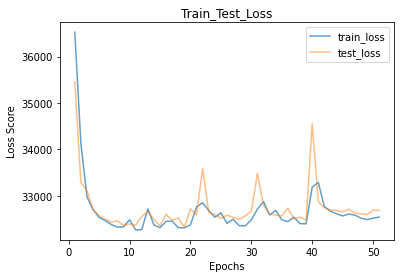

52
Train Epoch: 52 [0/7471 (0%)]	Loss: 33755.722656
Train Epoch: 52 [160/7471 (2%)]	Loss: 32598.228516
Train Epoch: 52 [320/7471 (4%)]	Loss: 31289.109375
Train Epoch: 52 [480/7471 (6%)]	Loss: 31861.681641
Train Epoch: 52 [640/7471 (9%)]	Loss: 32421.013672
Train Epoch: 52 [800/7471 (11%)]	Loss: 32016.611328
Train Epoch: 52 [960/7471 (13%)]	Loss: 32244.951172
Train Epoch: 52 [1120/7471 (15%)]	Loss: 33252.929688
Train Epoch: 52 [1280/7471 (17%)]	Loss: 31974.308594
Train Epoch: 52 [1440/7471 (19%)]	Loss: 31861.845703
Train Epoch: 52 [1600/7471 (21%)]	Loss: 33227.296875
Train Epoch: 52 [1760/7471 (24%)]	Loss: 31461.744141
Train Epoch: 52 [1920/7471 (26%)]	Loss: 32467.287109
Train Epoch: 52 [2080/7471 (28%)]	Loss: 33070.742188
Train Epoch: 52 [2240/7471 (30%)]	Loss: 31327.193359
Train Epoch: 52 [2400/7471 (32%)]	Loss: 31619.533203
Train Epoch: 52 [2560/7471 (34%)]	Loss: 31565.712891
Train Epoch: 52 [2720/7471 (36%)]	Loss: 33192.546875
Train Epoch: 52 [2880/7471 (39%)]	Loss: 31037.037109
Trai

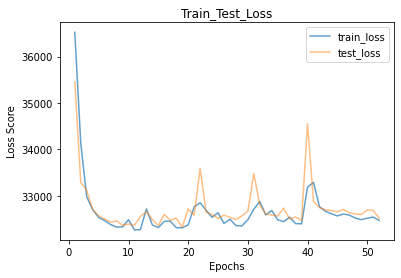

53
Train Epoch: 53 [0/7471 (0%)]	Loss: 32262.126953
Train Epoch: 53 [160/7471 (2%)]	Loss: 32022.273438
Train Epoch: 53 [320/7471 (4%)]	Loss: 32914.261719
Train Epoch: 53 [480/7471 (6%)]	Loss: 33225.320312
Train Epoch: 53 [640/7471 (9%)]	Loss: 33166.203125
Train Epoch: 53 [800/7471 (11%)]	Loss: 31331.832031
Train Epoch: 53 [960/7471 (13%)]	Loss: 33049.246094
Train Epoch: 53 [1120/7471 (15%)]	Loss: 30693.734375
Train Epoch: 53 [1280/7471 (17%)]	Loss: 31842.933594
Train Epoch: 53 [1440/7471 (19%)]	Loss: 32452.851562
Train Epoch: 53 [1600/7471 (21%)]	Loss: 32253.974609
Train Epoch: 53 [1760/7471 (24%)]	Loss: 33050.582031
Train Epoch: 53 [1920/7471 (26%)]	Loss: 32667.900391
Train Epoch: 53 [2080/7471 (28%)]	Loss: 32975.949219
Train Epoch: 53 [2240/7471 (30%)]	Loss: 34259.718750
Train Epoch: 53 [2400/7471 (32%)]	Loss: 33372.378906
Train Epoch: 53 [2560/7471 (34%)]	Loss: 32013.478516
Train Epoch: 53 [2720/7471 (36%)]	Loss: 31596.367188
Train Epoch: 53 [2880/7471 (39%)]	Loss: 31780.945312
Trai

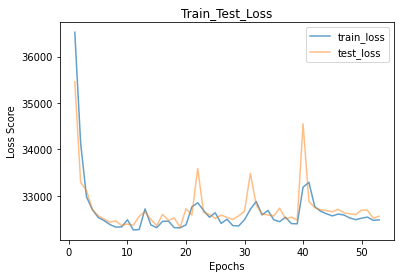

54
Train Epoch: 54 [0/7471 (0%)]	Loss: 31953.279297
Train Epoch: 54 [160/7471 (2%)]	Loss: 33731.964844
Train Epoch: 54 [320/7471 (4%)]	Loss: 32472.283203
Train Epoch: 54 [480/7471 (6%)]	Loss: 32259.552734
Train Epoch: 54 [640/7471 (9%)]	Loss: 32715.919922
Train Epoch: 54 [800/7471 (11%)]	Loss: 32598.140625
Train Epoch: 54 [960/7471 (13%)]	Loss: 33739.937500
Train Epoch: 54 [1120/7471 (15%)]	Loss: 31921.222656
Train Epoch: 54 [1280/7471 (17%)]	Loss: 30641.085938
Train Epoch: 54 [1440/7471 (19%)]	Loss: 31485.853516
Train Epoch: 54 [1600/7471 (21%)]	Loss: 31096.396484
Train Epoch: 54 [1760/7471 (24%)]	Loss: 30576.062500
Train Epoch: 54 [1920/7471 (26%)]	Loss: 33292.871094
Train Epoch: 54 [2080/7471 (28%)]	Loss: 33435.187500
Train Epoch: 54 [2240/7471 (30%)]	Loss: 31554.949219
Train Epoch: 54 [2400/7471 (32%)]	Loss: 33369.871094
Train Epoch: 54 [2560/7471 (34%)]	Loss: 33377.863281
Train Epoch: 54 [2720/7471 (36%)]	Loss: 31717.451172
Train Epoch: 54 [2880/7471 (39%)]	Loss: 33202.394531
Trai

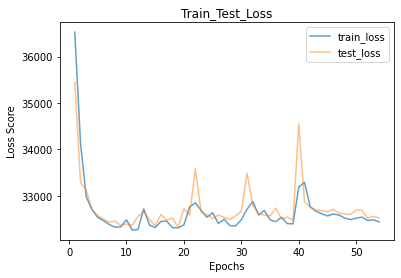

55
Train Epoch: 55 [0/7471 (0%)]	Loss: 33115.011719
Train Epoch: 55 [160/7471 (2%)]	Loss: 31322.781250
Train Epoch: 55 [320/7471 (4%)]	Loss: 32077.822266
Train Epoch: 55 [480/7471 (6%)]	Loss: 33395.917969
Train Epoch: 55 [640/7471 (9%)]	Loss: 32356.958984
Train Epoch: 55 [800/7471 (11%)]	Loss: 33390.777344
Train Epoch: 55 [960/7471 (13%)]	Loss: 31718.552734
Train Epoch: 55 [1120/7471 (15%)]	Loss: 30780.173828
Train Epoch: 55 [1280/7471 (17%)]	Loss: 31713.816406
Train Epoch: 55 [1440/7471 (19%)]	Loss: 30636.623047
Train Epoch: 55 [1600/7471 (21%)]	Loss: 33722.855469
Train Epoch: 55 [1760/7471 (24%)]	Loss: 31831.658203
Train Epoch: 55 [1920/7471 (26%)]	Loss: 31349.832031
Train Epoch: 55 [2080/7471 (28%)]	Loss: 31445.878906
Train Epoch: 55 [2240/7471 (30%)]	Loss: 32016.349609
Train Epoch: 55 [2400/7471 (32%)]	Loss: 32555.708984
Train Epoch: 55 [2560/7471 (34%)]	Loss: 32441.296875
Train Epoch: 55 [2720/7471 (36%)]	Loss: 32613.925781
Train Epoch: 55 [2880/7471 (39%)]	Loss: 33083.792969
Trai

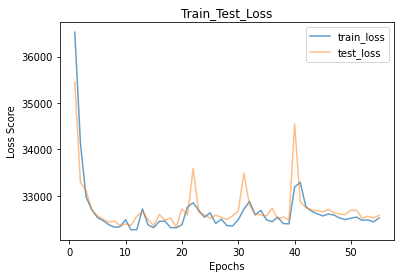

56
Train Epoch: 56 [0/7471 (0%)]	Loss: 33252.667969
Train Epoch: 56 [160/7471 (2%)]	Loss: 32551.363281
Train Epoch: 56 [320/7471 (4%)]	Loss: 32787.851562
Train Epoch: 56 [480/7471 (6%)]	Loss: 32487.398438
Train Epoch: 56 [640/7471 (9%)]	Loss: 33064.914062
Train Epoch: 56 [800/7471 (11%)]	Loss: 33488.703125
Train Epoch: 56 [960/7471 (13%)]	Loss: 32992.929688
Train Epoch: 56 [1120/7471 (15%)]	Loss: 31371.994141
Train Epoch: 56 [1280/7471 (17%)]	Loss: 32767.710938
Train Epoch: 56 [1440/7471 (19%)]	Loss: 31312.904297
Train Epoch: 56 [1600/7471 (21%)]	Loss: 33512.203125
Train Epoch: 56 [1760/7471 (24%)]	Loss: 31406.519531
Train Epoch: 56 [1920/7471 (26%)]	Loss: 33806.132812
Train Epoch: 56 [2080/7471 (28%)]	Loss: 33363.718750
Train Epoch: 56 [2240/7471 (30%)]	Loss: 32748.437500
Train Epoch: 56 [2400/7471 (32%)]	Loss: 31202.357422
Train Epoch: 56 [2560/7471 (34%)]	Loss: 32591.539062
Train Epoch: 56 [2720/7471 (36%)]	Loss: 33364.207031
Train Epoch: 56 [2880/7471 (39%)]	Loss: 33186.382812
Trai

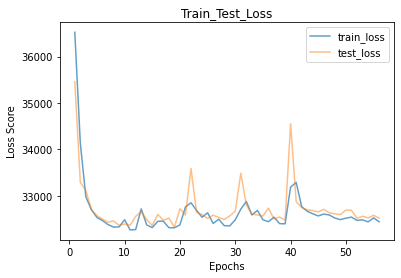

57
Train Epoch: 57 [0/7471 (0%)]	Loss: 31495.126953
Train Epoch: 57 [160/7471 (2%)]	Loss: 32648.359375
Train Epoch: 57 [320/7471 (4%)]	Loss: 31510.748047
Train Epoch: 57 [480/7471 (6%)]	Loss: 32811.695312
Train Epoch: 57 [640/7471 (9%)]	Loss: 31807.177734
Train Epoch: 57 [800/7471 (11%)]	Loss: 31829.855469
Train Epoch: 57 [960/7471 (13%)]	Loss: 32464.175781
Train Epoch: 57 [1120/7471 (15%)]	Loss: 30411.865234
Train Epoch: 57 [1280/7471 (17%)]	Loss: 31730.521484
Train Epoch: 57 [1440/7471 (19%)]	Loss: 31348.177734
Train Epoch: 57 [1600/7471 (21%)]	Loss: 32845.492188
Train Epoch: 57 [1760/7471 (24%)]	Loss: 32764.373047
Train Epoch: 57 [1920/7471 (26%)]	Loss: 33103.445312
Train Epoch: 57 [2080/7471 (28%)]	Loss: 34125.632812
Train Epoch: 57 [2240/7471 (30%)]	Loss: 30165.939453
Train Epoch: 57 [2400/7471 (32%)]	Loss: 33284.183594
Train Epoch: 57 [2560/7471 (34%)]	Loss: 33418.308594
Train Epoch: 57 [2720/7471 (36%)]	Loss: 32330.425781
Train Epoch: 57 [2880/7471 (39%)]	Loss: 33117.468750
Trai

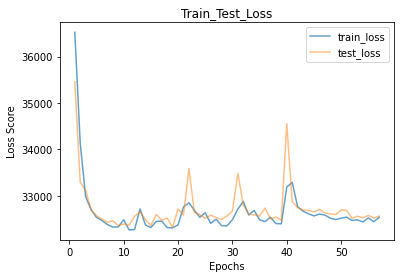

58
Train Epoch: 58 [0/7471 (0%)]	Loss: 31275.142578
Train Epoch: 58 [160/7471 (2%)]	Loss: 33224.406250
Train Epoch: 58 [320/7471 (4%)]	Loss: 32067.175781
Train Epoch: 58 [480/7471 (6%)]	Loss: 31619.757812
Train Epoch: 58 [640/7471 (9%)]	Loss: 31756.250000
Train Epoch: 58 [800/7471 (11%)]	Loss: 33166.933594
Train Epoch: 58 [960/7471 (13%)]	Loss: 32974.675781
Train Epoch: 58 [1120/7471 (15%)]	Loss: 32966.835938
Train Epoch: 58 [1280/7471 (17%)]	Loss: 32301.492188
Train Epoch: 58 [1440/7471 (19%)]	Loss: 32830.339844
Train Epoch: 58 [1600/7471 (21%)]	Loss: 33355.132812
Train Epoch: 58 [1760/7471 (24%)]	Loss: 32539.894531
Train Epoch: 58 [1920/7471 (26%)]	Loss: 32593.048828
Train Epoch: 58 [2080/7471 (28%)]	Loss: 33445.425781
Train Epoch: 58 [2240/7471 (30%)]	Loss: 32832.671875
Train Epoch: 58 [2400/7471 (32%)]	Loss: 32529.148438
Train Epoch: 58 [2560/7471 (34%)]	Loss: 32357.351562
Train Epoch: 58 [2720/7471 (36%)]	Loss: 32764.144531
Train Epoch: 58 [2880/7471 (39%)]	Loss: 32465.681641
Trai

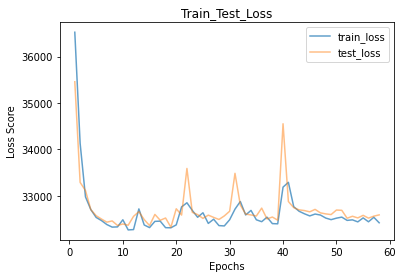

59
Train Epoch: 59 [0/7471 (0%)]	Loss: 32761.412109
Train Epoch: 59 [160/7471 (2%)]	Loss: 34078.398438
Train Epoch: 59 [320/7471 (4%)]	Loss: 32208.341797
Train Epoch: 59 [480/7471 (6%)]	Loss: 32077.275391
Train Epoch: 59 [640/7471 (9%)]	Loss: 32362.826172
Train Epoch: 59 [800/7471 (11%)]	Loss: 33325.210938
Train Epoch: 59 [960/7471 (13%)]	Loss: 32816.750000
Train Epoch: 59 [1120/7471 (15%)]	Loss: 32338.296875
Train Epoch: 59 [1280/7471 (17%)]	Loss: 33400.207031
Train Epoch: 59 [1440/7471 (19%)]	Loss: 32635.939453
Train Epoch: 59 [1600/7471 (21%)]	Loss: 32501.183594
Train Epoch: 59 [1760/7471 (24%)]	Loss: 31740.998047
Train Epoch: 59 [1920/7471 (26%)]	Loss: 31760.755859
Train Epoch: 59 [2080/7471 (28%)]	Loss: 33055.851562
Train Epoch: 59 [2240/7471 (30%)]	Loss: 33592.921875
Train Epoch: 59 [2400/7471 (32%)]	Loss: 31880.142578
Train Epoch: 59 [2560/7471 (34%)]	Loss: 30918.150391
Train Epoch: 59 [2720/7471 (36%)]	Loss: 32601.109375
Train Epoch: 59 [2880/7471 (39%)]	Loss: 33737.945312
Trai

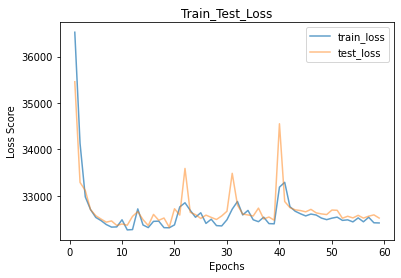

60
Train Epoch: 60 [0/7471 (0%)]	Loss: 32789.914062
Train Epoch: 60 [160/7471 (2%)]	Loss: 31632.542969
Train Epoch: 60 [320/7471 (4%)]	Loss: 33186.222656
Train Epoch: 60 [480/7471 (6%)]	Loss: 31748.220703
Train Epoch: 60 [640/7471 (9%)]	Loss: 32172.544922
Train Epoch: 60 [800/7471 (11%)]	Loss: 32407.787109
Train Epoch: 60 [960/7471 (13%)]	Loss: 32641.609375
Train Epoch: 60 [1120/7471 (15%)]	Loss: 32239.292969
Train Epoch: 60 [1280/7471 (17%)]	Loss: 32693.763672
Train Epoch: 60 [1440/7471 (19%)]	Loss: 31666.228516
Train Epoch: 60 [1600/7471 (21%)]	Loss: 32639.753906
Train Epoch: 60 [1760/7471 (24%)]	Loss: 32579.583984
Train Epoch: 60 [1920/7471 (26%)]	Loss: 31684.607422
Train Epoch: 60 [2080/7471 (28%)]	Loss: 32044.992188
Train Epoch: 60 [2240/7471 (30%)]	Loss: 32798.550781
Train Epoch: 60 [2400/7471 (32%)]	Loss: 30538.878906
Train Epoch: 60 [2560/7471 (34%)]	Loss: 33230.335938
Train Epoch: 60 [2720/7471 (36%)]	Loss: 32748.388672
Train Epoch: 60 [2880/7471 (39%)]	Loss: 30616.490234
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


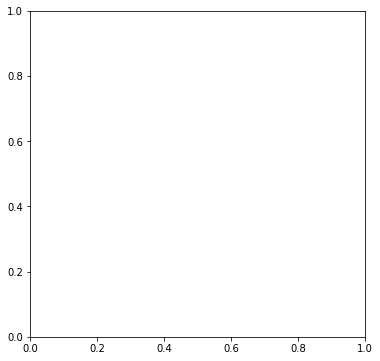

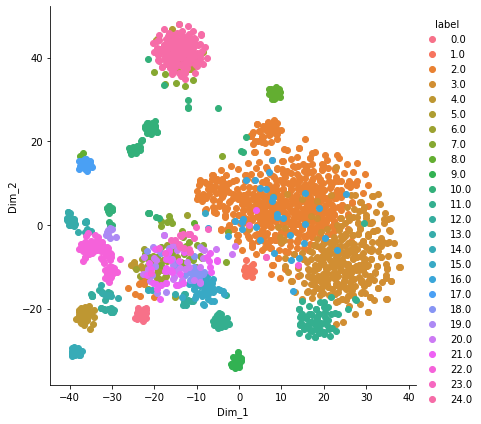

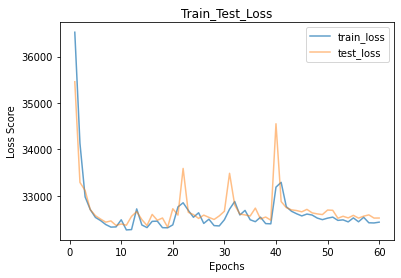

In [22]:
epochs = 60

for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)
        # https://stackoverflow.com/questions/40766909/suggestions-to-plot-overlapping-lines-in-matplotlib
        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss", alpha=0.7)
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./Exp05_results/plot_train_test_loss/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()

        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),
                       './Exp05_results/recon_sampling/sampling_' + str(epoch) + '.png')

### Training 일지

1. 생각보다 초기 학습이 잘 되고 있는 것 같다?!
 